In [1]:

#==================================
# BLOCK 1
#==================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
#==================================
# BLOCK 2
#==================================
# Load the dataset
ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')

# Select two consecutive time steps (you can change the index)
time_idx = 30  # Middle of the simulation
X_init = ds.isel(time=time_idx)
X_target = ds.isel(time=time_idx + 100)

# Extract time information
dt = float((X_target.time - X_init.time) / np.timedelta64(1, 's'))
print(f"Time step size: {dt} seconds")

# Print data dimensions
print("\nData dimensions:")
for var in ['u', 'w', 'b', 'p_dyn']:
    if var in ds:
        print(f"{var}: {ds[var].shape}")

/tmp/ipykernel_36/910939626.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')


Time step size: 50.0 seconds

Data dimensions:
u: (201, 256, 256)
w: (201, 257, 256)
b: (201, 256, 256)
p_dyn: (201, 256, 256)


In [3]:
#==================================
# BLOCK 3
#==================================
def interpolate_to_common_grid(field, target_shape=(256, 256)):

    if field.shape == target_shape:
        return field

    # Use PyTorch for interpolation
    field_tensor = torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0)
    interpolated = F.interpolate(field_tensor, size=target_shape, mode='bilinear', align_corners=True)
    return interpolated.squeeze().numpy()

# Extract fields from X_init (initial state)
u_init = X_init['u'].values
w_init = X_init['w'].values
b_init = X_init['b'].values
p_dyn_init = X_init['p_dyn'].values

# Extract fields from X_target (final state)
u_target = X_target['u'].values
w_target = X_target['w'].values
b_target = X_target['b'].values # Target buoyancy for comparison

# Interpolate all velocity fields to the common grid
u_init_interp = interpolate_to_common_grid(u_init, (256, 256))
w_init_interp = interpolate_to_common_grid(w_init, (256, 256))
u_target_interp = interpolate_to_common_grid(u_target, (256, 256))
w_target_interp = interpolate_to_common_grid(w_target, (256, 256))


print("Original shapes:")
print(f"u_init: {u_init.shape}, w_init: {w_init.shape}")
print(f"u_target: {u_target.shape}, w_target: {w_target.shape}")
print("\nAfter interpolation:")
print(f"u_init_interp: {u_init_interp.shape}, w_init_interp: {w_init_interp.shape}")
print(f"u_target_interp: {u_target_interp.shape}, w_target_interp: {w_target_interp.shape}")

Original shapes:
u_init: (256, 256), w_init: (257, 256)
u_target: (256, 256), w_target: (257, 256)

After interpolation:
u_init_interp: (256, 256), w_init_interp: (256, 256)
u_target_interp: (256, 256), w_target_interp: (256, 256)


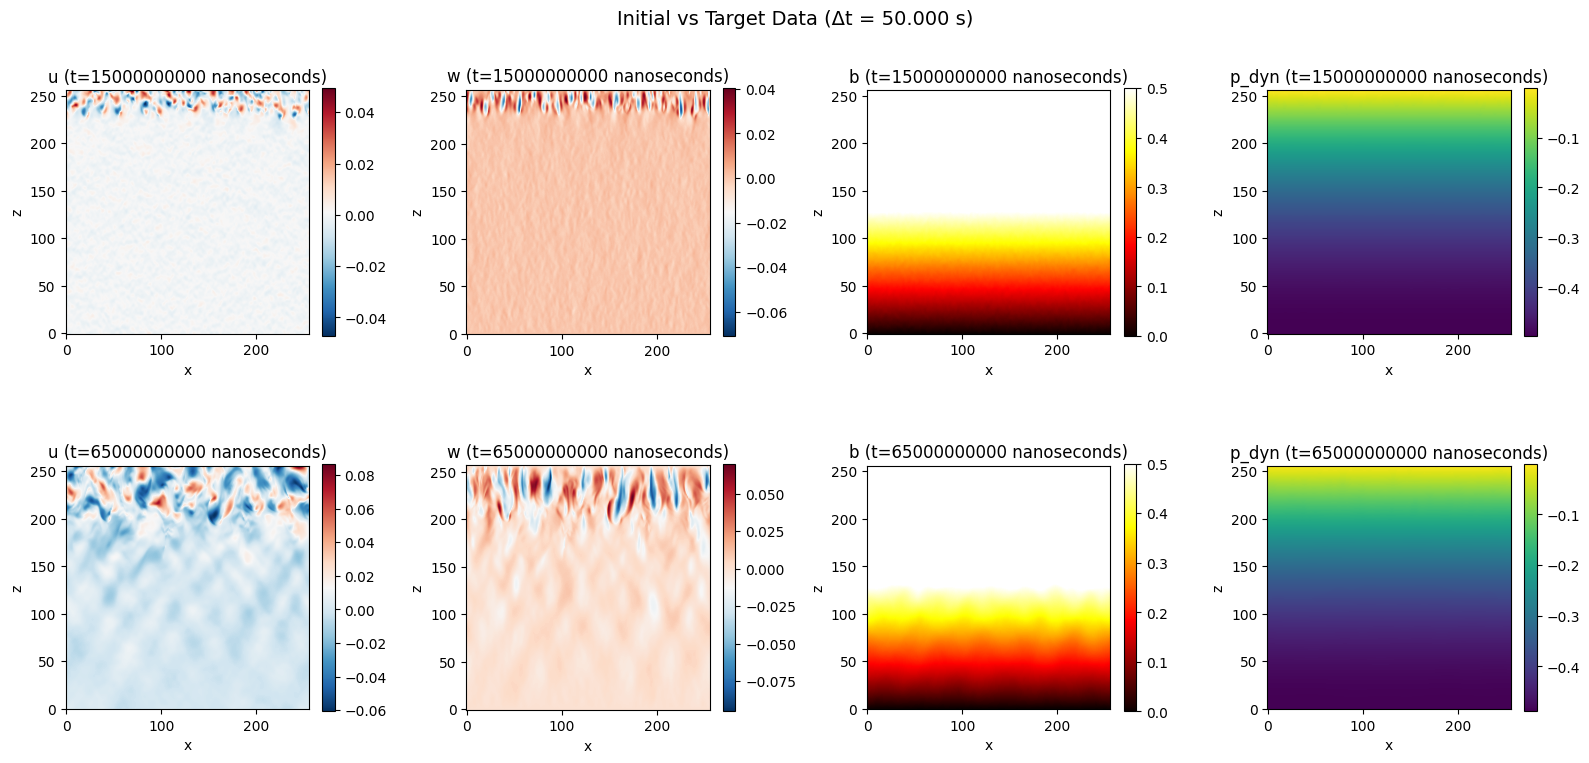


Field statistics:
Initial data:
  u: min=-0.0472, max=0.0493, mean=-0.0000
  w: min=-0.0709, max=0.0403, mean=0.0000
  b: min=0.0012, max=0.9433, mean=0.4968
  p: min=-0.4971, max=-0.0013, mean=-0.3305

Target data:
  u: min=-0.0607, max=0.0867, mean=-0.0000
  w: min=-0.0951, max=0.0700, mean=-0.0000
  b: min=0.0018, max=0.8653, mean=0.4884
  p: min=-0.4890, max=-0.0000, mean=-0.3226

Changes from initial to target:
  Δb_max: 0.180698
  Δb_mean: 0.014487


In [4]:
#==================================
# BLOCK 4
#==================================
# Create visualization of initial and target data
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Define common colormaps
cmap_velocity = 'RdBu_r'
cmap_buoyancy = 'hot'
cmap_pressure = 'viridis'

# Plot initial data (t = t0)
im1 = axes[0, 0].imshow(u_init, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[0, 0].set_title(f'u (t={X_init.time.values})', fontsize=12)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

im2 = axes[0, 1].imshow(w_init, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[0, 1].set_title(f'w (t={X_init.time.values})', fontsize=12)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

im3 = axes[0, 2].imshow(b_init, aspect='equal', cmap=cmap_buoyancy, origin='lower', vmin=0, vmax=0.5)
axes[0, 2].set_title(f'b (t={X_init.time.values})', fontsize=12)
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('z')
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

im4 = axes[0, 3].imshow(p_dyn_init, aspect='equal', cmap=cmap_pressure, origin='lower')
axes[0, 3].set_title(f'p_dyn (t={X_init.time.values})', fontsize=12)
axes[0, 3].set_xlabel('x')
axes[0, 3].set_ylabel('z')
plt.colorbar(im4, ax=axes[0, 3], fraction=0.046)

# Plot target data (t = t0 + dt)
u_target = X_target['u'].values
w_target = X_target['w'].values
p_dyn_target = X_target['p_dyn'].values

im5 = axes[1, 0].imshow(u_target, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[1, 0].set_title(f'u (t={X_target.time.values})', fontsize=12)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im5, ax=axes[1, 0], fraction=0.046)

im6 = axes[1, 1].imshow(w_target, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[1, 1].set_title(f'w (t={X_target.time.values})', fontsize=12)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im6, ax=axes[1, 1], fraction=0.046)

im7 = axes[1, 2].imshow(b_target, aspect='equal', cmap=cmap_buoyancy, origin='lower', vmin=0, vmax=0.5)
axes[1, 2].set_title(f'b (t={X_target.time.values})', fontsize=12)
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('z')
plt.colorbar(im7, ax=axes[1, 2], fraction=0.046)

im8 = axes[1, 3].imshow(p_dyn_target, aspect='equal', cmap=cmap_pressure, origin='lower')
axes[1, 3].set_title(f'p_dyn (t={X_target.time.values})', fontsize=12)
axes[1, 3].set_xlabel('x')
axes[1, 3].set_ylabel('z')
plt.colorbar(im8, ax=axes[1, 3], fraction=0.046)

plt.suptitle(f'Initial vs Target Data (Δt = {dt:.3f} s)', fontsize=14)
plt.tight_layout()
plt.show()

# Print statistics
print("\nField statistics:")
print("Initial data:")
print(f"  u: min={u_init.min():.4f}, max={u_init.max():.4f}, mean={u_init.mean():.4f}")
print(f"  w: min={w_init.min():.4f}, max={w_init.max():.4f}, mean={w_init.mean():.4f}")
print(f"  b: min={b_init.min():.4f}, max={b_init.max():.4f}, mean={b_init.mean():.4f}")
print(f"  p: min={p_dyn_init.min():.4f}, max={p_dyn_init.max():.4f}, mean={p_dyn_init.mean():.4f}")

print("\nTarget data:")
print(f"  u: min={u_target.min():.4f}, max={u_target.max():.4f}, mean={u_target.mean():.4f}")
print(f"  w: min={w_target.min():.4f}, max={w_target.max():.4f}, mean={w_target.mean():.4f}")
print(f"  b: min={b_target.min():.4f}, max={b_target.max():.4f}, mean={b_target.mean():.4f}")
print(f"  p: min={p_dyn_target.min():.4f}, max={p_dyn_target.max():.4f}, mean={p_dyn_target.mean():.4f}")

# Calculate and display changes
print("\nChanges from initial to target:")
print(f"  Δb_max: {np.abs(b_target - b_init).max():.6f}")
print(f"  Δb_mean: {np.abs(b_target - b_init).mean():.6f}")

In [5]:
#==================================
# BLOCK 5
#==================================
# Normalize fields
def normalize_field(field):
    mean = np.mean(field)
    std = np.std(field)
    return (field - mean) / (std + 1e-8), mean, std

# Normalize initial fields (for model input)
u_init_norm, u_init_mean, u_init_std = normalize_field(u_init_interp)
w_init_norm, w_init_mean, w_init_std = normalize_field(w_init_interp)
b_norm, b_mean, b_std = normalize_field(b_init)
p_norm, p_mean, p_std = normalize_field(p_dyn_init)

# Normalize target velocity fields (for physics loss)
u_target_norm, u_target_mean, u_target_std = normalize_field(u_target_interp)
w_target_norm, w_target_mean, w_target_std = normalize_field(w_target_interp)


# Store normalization parameters for denormalization later
norm_params = {
    'b': (b_mean, b_std),
    'p': (p_mean, p_std),
    'u_init': (u_init_mean, u_init_std),
    'w_init': (w_init_mean, w_init_std),
    'u_target': (u_target_mean, u_target_std),
    'w_target': (w_target_mean, w_target_std),
}

print("Normalization statistics:")
for field, (mean, std) in norm_params.items():
    print(f"{field}: mean={mean:.4f}, std={std:.4f}")

Normalization statistics:
b: mean=0.4968, std=0.2838
p: mean=-0.3305, std=0.1489
u_init: mean=-0.0000, std=0.0045
w_init: mean=0.0000, std=0.0053
u_target: mean=-0.0000, std=0.0118
w_target: mean=-0.0000, std=0.0124


In [6]:
#==================================
# BLOCK 6
#==================================
class CNNBranchNet(nn.Module):
    """6-layer CNN for processing spatial fields"""
    def __init__(self, in_channels=4, hidden_dim=64, out_dim=128):
        super(CNNBranchNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim*2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim*2)
        
        self.conv3 = nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_dim*2)
        
        self.conv4 = nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_dim*4)
        
        self.conv5 = nn.Conv2d(hidden_dim*4, hidden_dim*4, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(hidden_dim*4)
        
        self.conv6 = nn.Conv2d(hidden_dim*4, out_dim, 3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.bn4(self.conv4(x)))
        x = self.activation(self.bn5(self.conv5(x)))
        x = self.conv6(x)
        x = self.pool(x)
        return x.squeeze(-1).squeeze(-1)

class MLPTrunkNet(nn.Module):
    """6-layer MLP for processing time"""
    def __init__(self, in_dim=1, hidden_dim=64, out_dim=128):
        super(MLPTrunkNet, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.fc4 = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.fc5 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, out_dim)
        
        self.activation = nn.ReLU()
        
    def forward(self, t):
        t = self.activation(self.fc1(t))
        t = self.activation(self.fc2(t))
        t = self.activation(self.fc3(t))
        t = self.activation(self.fc4(t))
        t = self.activation(self.fc5(t))
        t = self.fc6(t)
        return t


class HybridDeepONet(nn.Module):
    """Hybrid DeepONet with better architecture"""
    def __init__(self, branch_dim=256, trunk_dim=256, grid_size=256):
        super(HybridDeepONet, self).__init__()
        
        self.branch_net = CNNBranchNet(in_channels=4, out_dim=branch_dim)
        self.trunk_net = MLPTrunkNet(in_dim=1, out_dim=trunk_dim)
        
        # Improved decoder
        self.decoder = nn.Sequential(
            nn.Linear(branch_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 2048),
            nn.GELU(),
            nn.LayerNorm(2048),
            nn.Linear(2048, 4096),
            nn.GELU(),
            nn.Linear(4096, grid_size * grid_size)
        )
        
        self.grid_size = grid_size
        
    def forward(self, spatial_fields, delta_t):
        # Branch network output
        branch_out = self.branch_net(spatial_fields)
        
        # Trunk network output  
        trunk_out = self.trunk_net(delta_t)
        
        # Combine via element-wise multiplication
        combined = branch_out * trunk_out
        
        # Decode to spatial field
        b_pred = self.decoder(combined)
        b_pred = b_pred.view(-1, self.grid_size, self.grid_size)
        
        return b_pred


In [7]:
#==================================
# BLOCK 7
#==================================
def compute_derivatives(field, dx, dz):
    """Compute spatial derivatives using finite differences with periodic BC in x"""
    if field.dim() == 2:
        field = field.unsqueeze(0)

    # x-derivatives with periodic padding
    field_padded = F.pad(field, (1, 1, 0, 0), mode='circular')
    df_dx = (field_padded[:, :, 2:] - field_padded[:, :, :-2]) / (2 * dx)

    # z-derivatives with one-sided at boundaries
    df_dz = torch.zeros_like(field)
    df_dz[:, 1:-1, :] = (field[:, 2:, :] - field[:, :-2, :]) / (2 * dz)
    df_dz[:, 0, :] = (field[:, 1, :] - field[:, 0, :]) / dz
    df_dz[:, -1, :] = (field[:, -1, :] - field[:, -2, :]) / dz

    return df_dx, df_dz

def physics_loss(b_pred_norm, u_target_norm, w_target_norm, b_init_norm, dx, dz, dt, kappa, norm_params):
    """
    Physics loss using final-state velocities for the advection term.
    All calculations are in physical space (denormalized).
    """
    # Denormalize predictions and fields using their respective stats
    b_mean, b_std = norm_params['b']
    u_target_mean, u_target_std = norm_params['u_target']
    w_target_mean, w_target_std = norm_params['w_target']

    b_pred = b_pred_norm * b_std + b_mean
    b_init = b_init_norm * b_std + b_mean
    u = u_target_norm * u_target_std + u_target_mean
    w = w_target_norm * w_target_std + w_target_mean

    # Compute derivatives of the predicted buoyancy (b_pred) in physical space
    db_dx, db_dz = compute_derivatives(b_pred, dx, dz)

    # Second derivatives for diffusion
    d2b_dx2, _ = compute_derivatives(db_dx, dx, dz)
    _, d2b_dz2 = compute_derivatives(db_dz, dx, dz)

    # Time derivative (finite difference)
    db_dt = (b_pred - b_init) / dt

    # Advection term using final-state u and w
    advection = u * db_dx + w * db_dz

    # Diffusion term
    diffusion = kappa * (d2b_dx2 + d2b_dz2)

    # Physics residual: ∂b/∂t + u·∇b - κ∇²b = 0
    residual = db_dt + advection - diffusion

    return torch.mean(residual**2)

def boundary_condition_loss(b_pred_norm, norm_params):
    """BC loss in physical space"""
    b_mean, b_std = norm_params['b']
    b_pred = b_pred_norm * b_std + b_mean

    top_bc = torch.mean((b_pred[:, -1, :] - 0.5)**2)
    bottom_bc = torch.mean((b_pred[:, 0, :])**2)

    return top_bc + bottom_bc

def initial_condition_loss(b_pred_norm, b_init_norm):
    """IC loss in normalized space for stability"""
    return torch.mean((b_pred_norm - b_init_norm)**2)

def smoothness_loss(b_pred_norm):
    """Smoothness in normalized space"""
    tv_z = torch.mean(torch.abs(b_pred_norm[:, 1:, :] - b_pred_norm[:, :-1, :]))
    tv_x = torch.mean(torch.abs(b_pred_norm[:, :, 1:] - b_pred_norm[:, :, :-1]))
    return tv_z + tv_x

In [8]:
#==================================
# BLOCK 8
#==================================
# Stack input fields (using initial state)
input_fields = np.stack([u_init_norm, w_init_norm, p_norm, b_norm], axis=0)
input_tensor = torch.FloatTensor(input_fields).unsqueeze(0).to(device)

# Time tensor
dt_tensor = torch.FloatTensor([[dt]]).to(device)

# Initial buoyancy tensor (for time derivative and IC loss)
b_init_tensor = torch.FloatTensor(b_norm).unsqueeze(0).to(device)

# Target velocity tensors (for physics loss advection term)
u_target_tensor = torch.FloatTensor(u_target_norm).unsqueeze(0).to(device)
w_target_tensor = torch.FloatTensor(w_target_norm).unsqueeze(0).to(device)


# Grid spacing
x_coords = X_init.x_caa.values
z_coords = X_init.z_aac.values
dx = float(x_coords[1] - x_coords[0])
dz = float(z_coords[1] - z_coords[0])

# Physical parameters
kappa = 1e-6 # thermal diffusivity (κ = ν/Pr, and Pr=1)

print(f"Grid spacing: dx={dx:.6f}, dz={dz:.6f}")
print(f"Thermal diffusivity: κ={kappa}")

Grid spacing: dx=0.007812, dz=0.003906
Thermal diffusivity: κ=1e-06


In [9]:
#==================================
# BLOCK 9
#==================================
# Initialize model
model = HybridDeepONet(branch_dim=128, trunk_dim=128, grid_size=256).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

# # Loss weights
# loss_weights = {
#     'physics': 1.0,
#     'bc': 10.0,
#     'ic': 0.1,
#     'smooth': 0.01,
#     'incomp': 0.0
# }

# print("\nLoss weights:")
# for key, value in loss_weights.items():
#     print(f"{key}: {value}")

Total parameters: 279,479,296


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
#==================================
# BLOCK 10
#==================================
torch.cuda.empty_cache()

# Training parameters
n_epochs = 1500
print_interval = 500

# Adaptive loss weights
loss_weights = {
    'physics': 50,  # Start small
    'bc': 100.0, # Strong BC enforcement
    'ic': 0.1,   # Moderate IC
    'smooth': 0.05  # Light smoothing
}

# Convert norm_params to tensor dict for GPU
norm_params_tensor = {k: v for k, v in norm_params.items()}

# Training history
history = {name: [] for name in ['total_loss', 'physics_loss', 'bc_loss', 'ic_loss', 'smooth_loss']}

# Training loop
model.train()
best_loss = float('inf')

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Forward pass
    b_pred_norm = model(input_tensor, dt_tensor)

    # Compute losses
    l_physics = physics_loss(b_pred_norm, u_target_tensor, w_target_tensor, b_init_tensor,
                            dx, dz, dt, kappa, norm_params_tensor)
    l_bc = boundary_condition_loss(b_pred_norm, norm_params_tensor)
    l_ic = initial_condition_loss(b_pred_norm, b_init_tensor)
    l_smooth = smoothness_loss(b_pred_norm)

    # Total loss
    total_loss = (loss_weights['physics'] * l_physics +
                 loss_weights['bc'] * l_bc +
                 loss_weights['ic'] * l_ic +
                 loss_weights['smooth'] * l_smooth)

    # Backward pass
    total_loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Adaptive weight adjustment every 500 epochs
    if epoch > 0 and epoch % 500 == 0:
        if l_physics.item() < 0.1:
            loss_weights['physics'] = min(loss_weights['physics'] * 1.5, 10.0)
    
    # Record history
    for name, loss in zip(['total_loss', 'physics_loss', 'bc_loss', 'ic_loss', 'smooth_loss'],
                        [total_loss, l_physics, l_bc, l_ic, l_smooth]):
        history[name].append(loss.item())

    # Learning rate scheduling
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
    else:
        if epoch > 700 and epoch % 200 == 0:
            for g in optimizer.param_groups:
                g['lr'] *= 0.95

    if (epoch) % print_interval == 0 or epoch+1 == n_epochs:
        print(f"Epoch {epoch}/{n_epochs} | Total: {total_loss.item():.6f} | Physics: {l_physics.item():.6f} | BC: {l_bc.item():.6f} | IC: {l_ic.item():.6f} | Smooth: {l_smooth.item():.6f}")

Epoch 0/1500 | Total: 26.244555 | Physics: 0.019354 | BC: 0.251507 | IC: 1.039751 | Smooth: 0.442806
Epoch 500/1500 | Total: 0.022567 | Physics: 0.000133 | BC: 0.000107 | IC: 0.026329 | Smooth: 0.051532
Epoch 1000/1500 | Total: 0.011437 | Physics: 0.000081 | BC: 0.000072 | IC: 0.010315 | Smooth: 0.048811
Epoch 1499/1500 | Total: 0.003639 | Physics: 0.000078 | BC: 0.000000 | IC: 0.009548 | Smooth: 0.038058


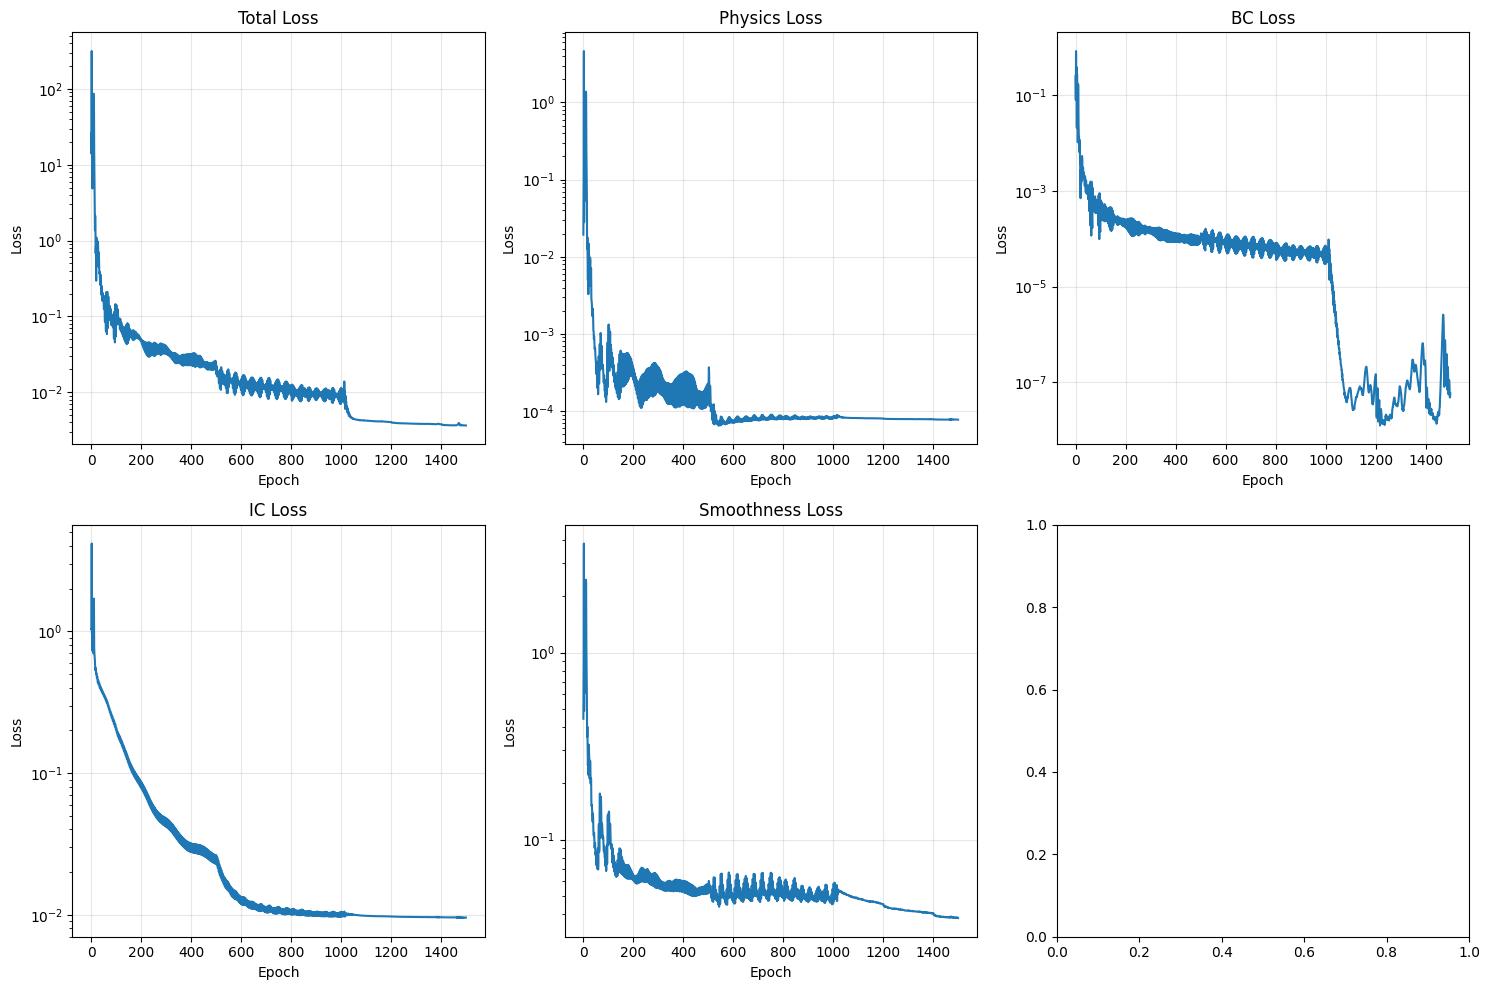

In [11]:
#==================================
# BLOCK 11
#==================================
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

loss_names = ['total_loss', 'physics_loss', 'bc_loss', 'ic_loss', 'smooth_loss']
loss_titles = ['Total Loss', 'Physics Loss', 'BC Loss', 'IC Loss', 'Smoothness Loss']

for idx, (loss_name, title) in enumerate(zip(loss_names, loss_titles)):
    ax = axes[idx]
    ax.semilogy(history[loss_name])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
#==================================
# BLOCK 12
#==================================
# Make prediction
model.eval()
with torch.no_grad():
    b_pred_norm = model(input_tensor, dt_tensor)
    b_pred_norm = b_pred_norm.squeeze().cpu().numpy()

# Denormalize prediction
b_pred = b_pred_norm * b_std + b_mean

# Also denormalize the target for comparison
b_target_denorm = b_target

print(f"Prediction shape: {b_pred.shape}")
print(f"Prediction range: [{b_pred.min():.4f}, {b_pred.max():.4f}]")
print(f"Target range: [{b_target_denorm.min():.4f}, {b_target_denorm.max():.4f}]")

Prediction shape: (256, 256)
Prediction range: [-0.0103, 1.0994]
Target range: [0.0018, 0.8653]


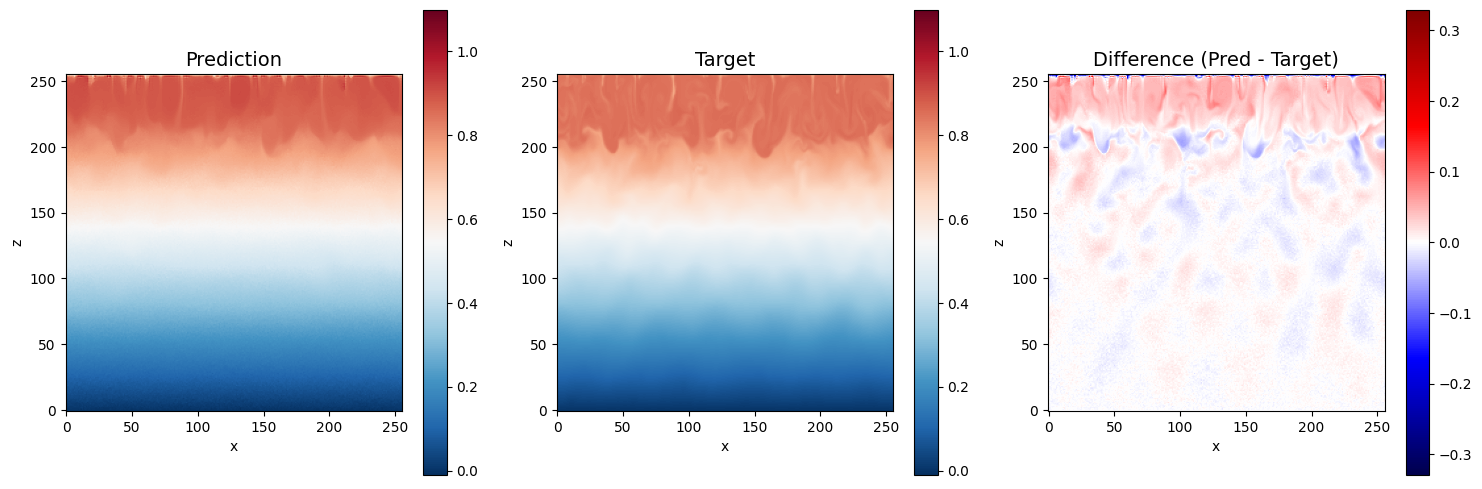


Error Metrics:
MSE: 0.000677
MAE: 0.012643
Relative Error: 3.8245%


In [13]:
#==================================
# BLOCK 13
#==================================
# Create side-by-side comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Common colorbar limits
vmin = min(b_pred.min(), b_target_denorm.min())
vmax = max(b_pred.max(), b_target_denorm.max())

# Plot prediction
im1 = axes[0].imshow(b_pred, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title('Prediction', fontsize=14)
axes[0].set_xlabel('x')
axes[0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0])

# Plot target
im2 = axes[1].imshow(b_target_denorm, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title('Target', fontsize=14)
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
plt.colorbar(im2, ax=axes[1])

# Plot difference
diff = b_pred - b_target_denorm
im3 = axes[2].imshow(diff, aspect='equal', cmap='seismic', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), origin='lower')
axes[2].set_title('Difference (Pred - Target)', fontsize=14)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Calculate error metrics
mse = np.mean((b_pred - b_target_denorm)**2)
mae = np.mean(np.abs(b_pred - b_target_denorm))
relative_error = np.mean(np.abs(b_pred - b_target_denorm) / (np.abs(b_target_denorm) + 1e-8))

print(f"\nError Metrics:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Relative Error: {relative_error:.4%}")

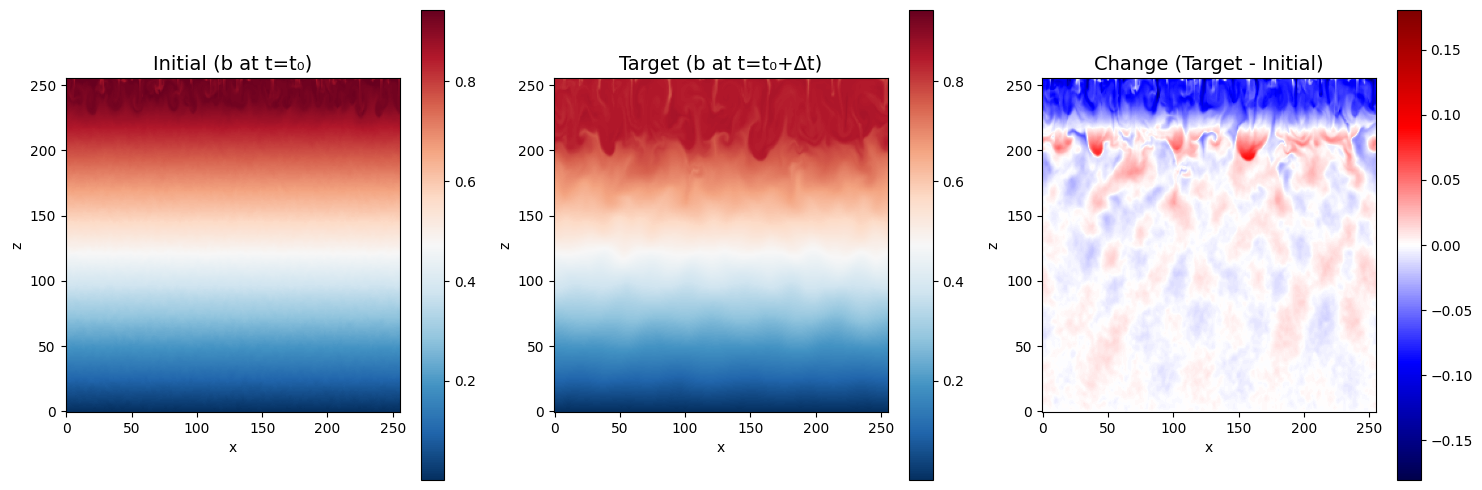

Initial buoyancy range: [0.0012, 0.9433]
Target buoyancy range: [0.0018, 0.8653]
Maximum change: 0.180698
Mean absolute change: 0.014487
Time step: 50.0 seconds
Relative change: 19.18%


In [14]:
#==================================
# BLOCK 14
#==================================
# Plot initial (b_init) vs target comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Common colorbar limits
vmin = min(b_init.min(), b_target.min())
vmax = max(b_init.max(), b_target.max())

# Plot initial buoyancy
im1 = axes[0].imshow(b_init, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title('Initial (b at t=t₀)', fontsize=14)
axes[0].set_xlabel('x')
axes[0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0])

# Plot target buoyancy
im2 = axes[1].imshow(b_target, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title('Target (b at t=t₀+Δt)', fontsize=14)
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
plt.colorbar(im2, ax=axes[1])

# Plot difference
diff = b_target - b_init
im3 = axes[2].imshow(diff, aspect='equal', cmap='seismic', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), origin='lower')
axes[2].set_title('Change (Target - Initial)', fontsize=14)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Print statistics
print(f"Initial buoyancy range: [{b_init.min():.4f}, {b_init.max():.4f}]")
print(f"Target buoyancy range: [{b_target.min():.4f}, {b_target.max():.4f}]")
print(f"Maximum change: {np.abs(diff).max():.6f}")
print(f"Mean absolute change: {np.abs(diff).mean():.6f}")
print(f"Time step: {dt} seconds")

# Check if we're in a quasi-steady state
relative_change = np.abs(diff).max() / (b_init.max() - b_init.min())
print(f"Relative change: {relative_change:.2%}")

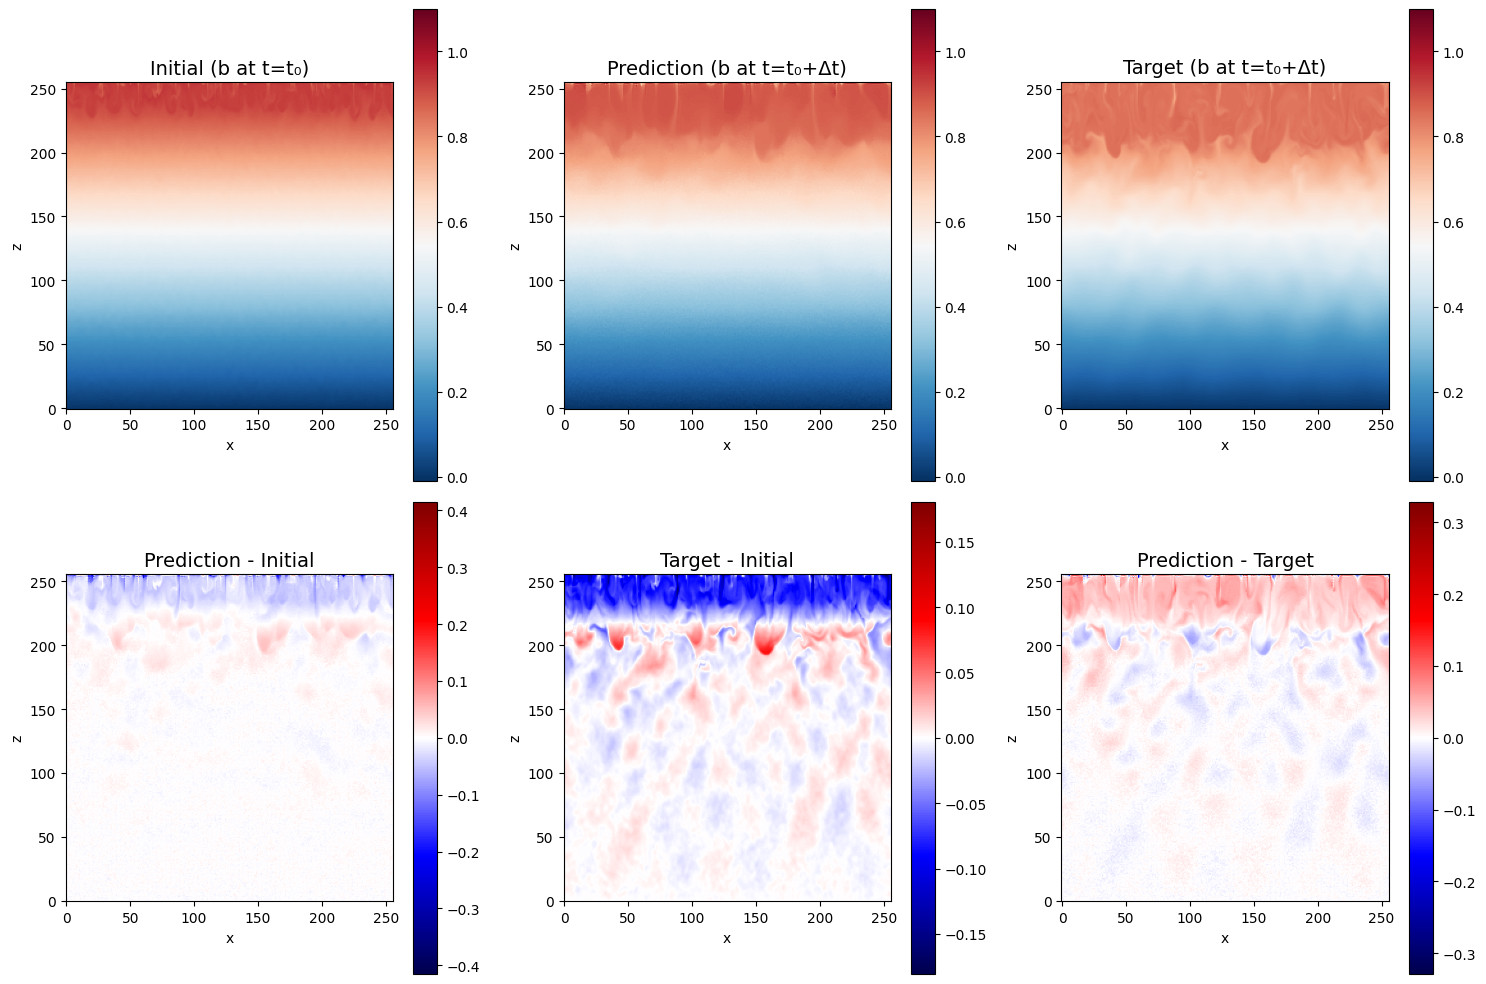

Field Statistics:
Initial:    min=0.0012, max=0.9433, mean=0.4968
Prediction: min=-0.0103, max=1.0994, mean=0.4931
Target:     min=0.0018, max=0.8653, mean=0.4884

Change Statistics:
Prediction - Initial: max change = 0.415395, mean = 0.009686
Target - Initial:     max change = 0.180698, mean = 0.014487
Prediction - Target:  max change = 0.328919, mean = 0.012643

Correlations:
Prediction vs Initial: 0.995397
Prediction vs Target:  0.995973


In [15]:
#==================================
# BLOCK 15
#==================================
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Common colorbar limits for buoyancy fields
vmin = min(b_init.min(), b_target.min(), b_pred.min())
vmax = max(b_init.max(), b_target.max(), b_pred.max())

# Row 1: The three buoyancy fields
# Initial
im1 = axes[0, 0].imshow(b_init, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[0, 0].set_title('Initial (b at t=t₀)', fontsize=14)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0])

# Prediction
im2 = axes[0, 1].imshow(b_pred, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[0, 1].set_title('Prediction (b at t=t₀+Δt)', fontsize=14)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1])

# Target
im3 = axes[0, 2].imshow(b_target, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[0, 2].set_title('Target (b at t=t₀+Δt)', fontsize=14)
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('z')
plt.colorbar(im3, ax=axes[0, 2])

# Row 2: Differences
# Prediction - Initial
diff_pred_init = b_pred - b_init
im4 = axes[1, 0].imshow(diff_pred_init, aspect='equal', cmap='seismic', 
                         vmin=-np.abs(diff_pred_init).max(), vmax=np.abs(diff_pred_init).max(), origin='lower')
axes[1, 0].set_title('Prediction - Initial', fontsize=14)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im4, ax=axes[1, 0])

# Target - Initial
diff_target_init = b_target - b_init
im5 = axes[1, 1].imshow(diff_target_init, aspect='equal', cmap='seismic', 
                         vmin=-np.abs(diff_target_init).max(), vmax=np.abs(diff_target_init).max(), origin='lower')
axes[1, 1].set_title('Target - Initial', fontsize=14)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im5, ax=axes[1, 1])

# Prediction - Target
diff_pred_target = b_pred - b_target
im6 = axes[1, 2].imshow(diff_pred_target, aspect='equal', cmap='seismic', 
                         vmin=-np.abs(diff_pred_target).max(), vmax=np.abs(diff_pred_target).max(), origin='lower')
axes[1, 2].set_title('Prediction - Target', fontsize=14)
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('z')
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Field Statistics:")
print(f"Initial:    min={b_init.min():.4f}, max={b_init.max():.4f}, mean={b_init.mean():.4f}")
print(f"Prediction: min={b_pred.min():.4f}, max={b_pred.max():.4f}, mean={b_pred.mean():.4f}")
print(f"Target:     min={b_target.min():.4f}, max={b_target.max():.4f}, mean={b_target.mean():.4f}")

print("\nChange Statistics:")
print(f"Prediction - Initial: max change = {np.abs(diff_pred_init).max():.6f}, mean = {np.abs(diff_pred_init).mean():.6f}")
print(f"Target - Initial:     max change = {np.abs(diff_target_init).max():.6f}, mean = {np.abs(diff_target_init).mean():.6f}")
print(f"Prediction - Target:  max change = {np.abs(diff_pred_target).max():.6f}, mean = {np.abs(diff_pred_target).mean():.6f}")

# Check if prediction is just copying initial
correlation_pred_init = np.corrcoef(b_pred.flatten(), b_init.flatten())[0, 1]
correlation_pred_target = np.corrcoef(b_pred.flatten(), b_target.flatten())[0, 1]
print(f"\nCorrelations:")
print(f"Prediction vs Initial: {correlation_pred_init:.6f}")
print(f"Prediction vs Target:  {correlation_pred_target:.6f}")

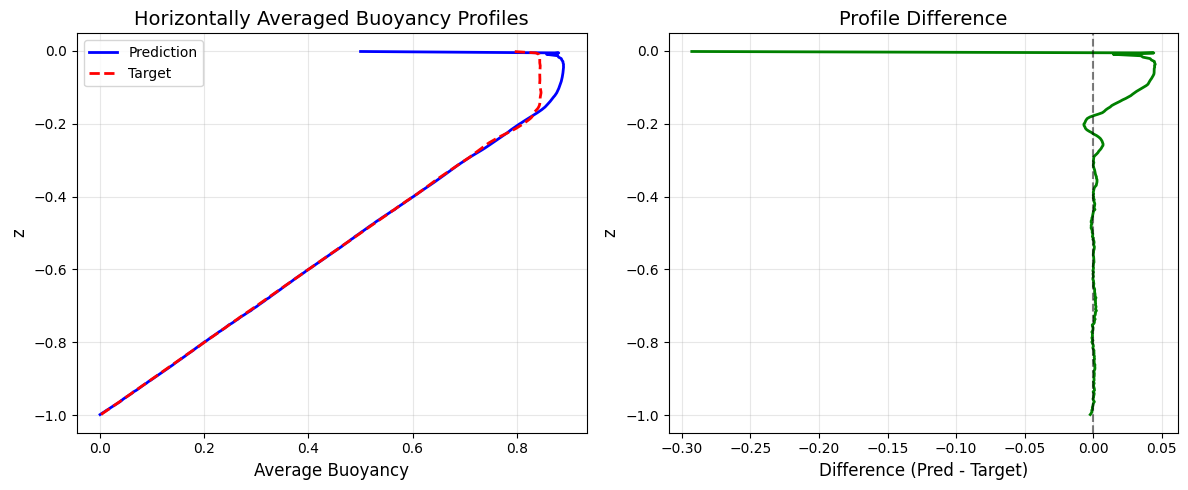


Profile Error Metrics:
Profile MSE: 0.000542
Profile MAE: 0.007656


In [16]:
#==================================
# BLOCK 16
#==================================
# Calculate horizontally averaged buoyancy profiles
avg_b_pred = np.mean(b_pred, axis=1)  # Average along x
avg_b_target = np.mean(b_target_denorm, axis=1)  # Average along x

# Create the comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Overlapped profiles
ax1.plot(avg_b_pred, z_coords, 'b-', linewidth=2, label='Prediction')
ax1.plot(avg_b_target, z_coords, 'r--', linewidth=2, label='Target')
ax1.set_xlabel('Average Buoyancy', fontsize=12)
ax1.set_ylabel('z', fontsize=12)
ax1.set_title('Horizontally Averaged Buoyancy Profiles', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Profile difference
profile_diff = avg_b_pred - avg_b_target
ax2.plot(profile_diff, z_coords, 'g-', linewidth=2)
ax2.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Difference (Pred - Target)', fontsize=12)
ax2.set_ylabel('z', fontsize=12)
ax2.set_title('Profile Difference', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate profile error metrics
profile_mse = np.mean((avg_b_pred - avg_b_target)**2)
profile_mae = np.mean(np.abs(avg_b_pred - avg_b_target))

print(f"\nProfile Error Metrics:")
print(f"Profile MSE: {profile_mse:.6f}")
print(f"Profile MAE: {profile_mae:.6f}")

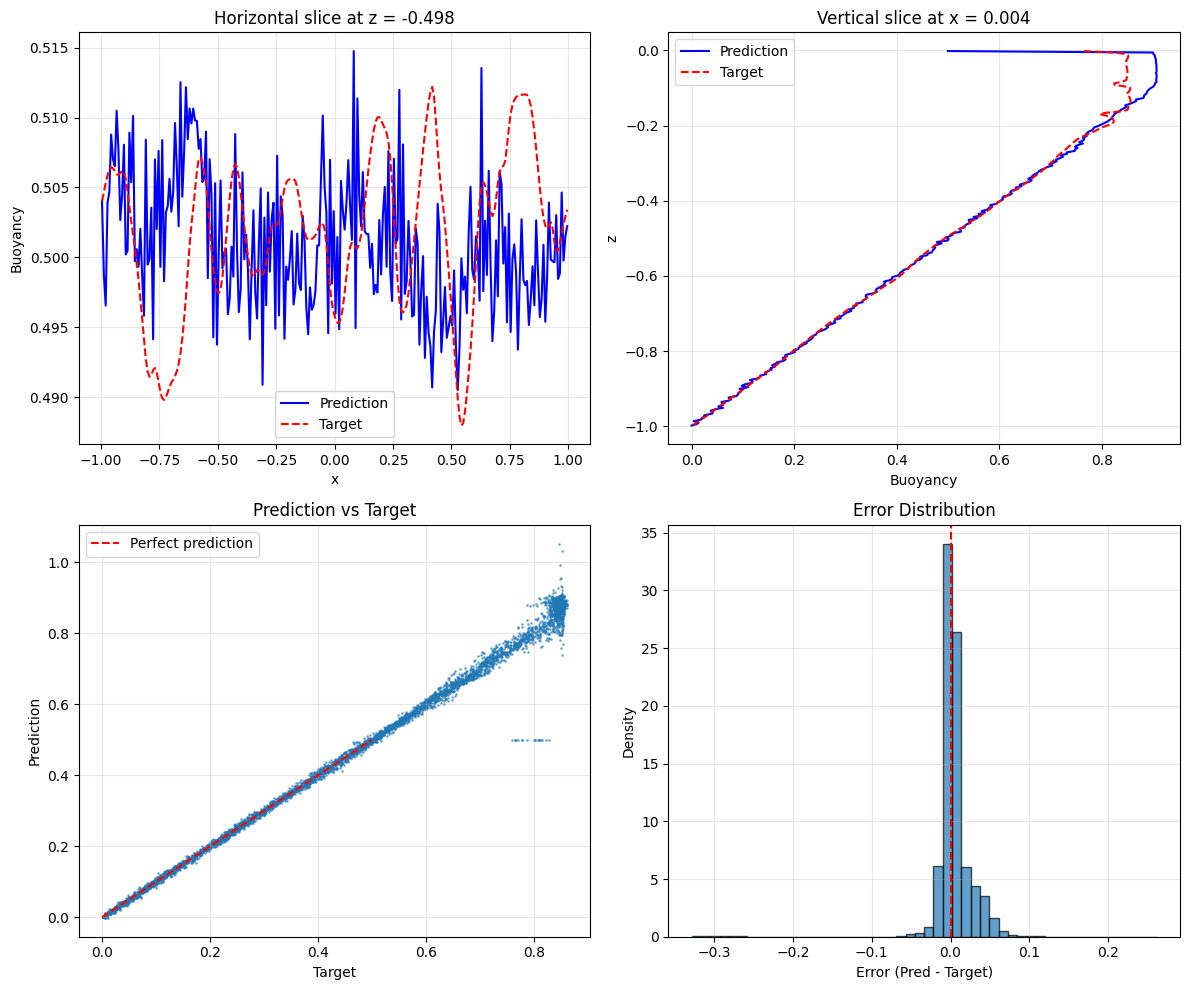

In [17]:
#==================================
# BLOCK 17
#==================================
# Create a more detailed analysis figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Horizontal slice at mid-height
mid_z_idx = len(z_coords) // 2
ax = axes[0, 0]
ax.plot(x_coords, b_pred[mid_z_idx, :], 'b-', label='Prediction')
ax.plot(x_coords, b_target_denorm[mid_z_idx, :], 'r--', label='Target')
ax.set_xlabel('x')
ax.set_ylabel('Buoyancy')
ax.set_title(f'Horizontal slice at z = {z_coords[mid_z_idx]:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Vertical slice at center
mid_x_idx = len(x_coords) // 2
ax = axes[0, 1]
ax.plot(b_pred[:, mid_x_idx], z_coords, 'b-', label='Prediction')
ax.plot(b_target_denorm[:, mid_x_idx], z_coords, 'r--', label='Target')
ax.set_xlabel('Buoyancy')
ax.set_ylabel('z')
ax.set_title(f'Vertical slice at x = {x_coords[mid_x_idx]:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Scatter plot: Prediction vs Target
ax = axes[1, 0]
sample_indices = np.random.choice(b_pred.size, 5000, replace=False)
ax.scatter(b_target_denorm.flatten()[sample_indices], 
           b_pred.flatten()[sample_indices], 
           alpha=0.5, s=1)
ax.plot([0, 0.5], [0, 0.5], 'r--', label='Perfect prediction')
ax.set_xlabel('Target')
ax.set_ylabel('Prediction')
ax.set_title('Prediction vs Target')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Error distribution
ax = axes[1, 1]
errors = (b_pred - b_target_denorm).flatten()
ax.hist(errors, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.set_xlabel('Error (Pred - Target)')
ax.set_ylabel('Density')
ax.set_title('Error Distribution')
ax.axvline(x=0, color='r', linestyle='--', label='Zero error')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Linear fit: b = 1.0048 * z + 1.0039
Deviation point: z = -0.1777 (index 210/256)


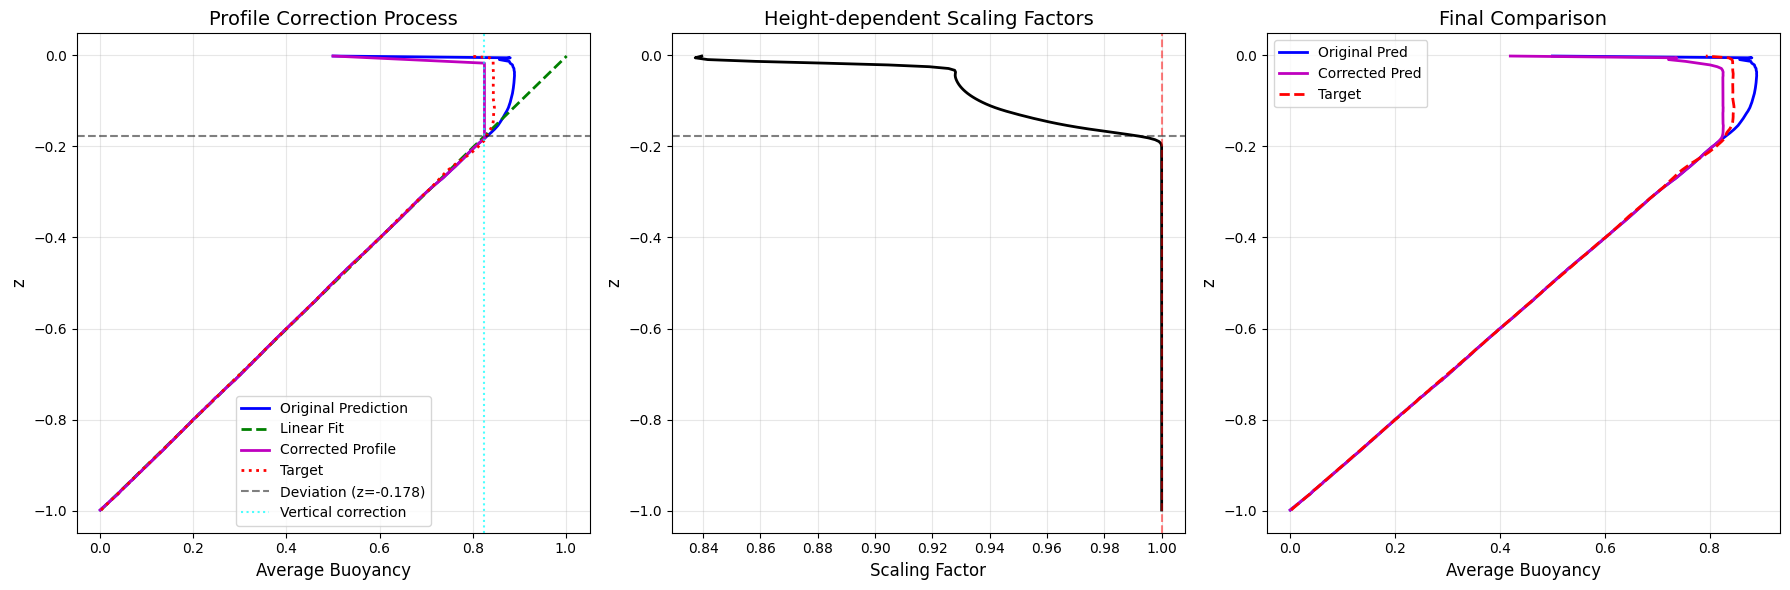


Error Metrics (Original):
MSE: 0.000677, MAE: 0.012643

Error Metrics (Corrected):
MSE: 0.000876, MAE: 0.011815

Improvement:
MSE reduction: -29.5%
MAE reduction: 6.5%

Maximum correction at z = -0.006 with factor = 0.84


In [46]:
#==================================
# BLOCK 18 - SIMPLIFIED: Linear Fit with Proper Deviation Detection
#==================================
from sklearn.linear_model import LinearRegression

# Get the horizontally averaged prediction profile
avg_b_pred = np.mean(b_pred, axis=1)
n_points = len(z_coords)

# Step 1: Fit linear model to most of the domain (bottom 80%)
# The bottom portion is clearly linear
linear_fit_points = int(0.8 * n_points)
z_linear = z_coords[:linear_fit_points].reshape(-1, 1)
b_linear = avg_b_pred[:linear_fit_points]

lr_model = LinearRegression()
lr_model.fit(z_linear, b_linear)

# Predict the linear trend for the entire height
z_all = z_coords.reshape(-1, 1)
linear_pred = lr_model.predict(z_all)

print(f"Linear fit: b = {lr_model.coef_[0]:.4f} * z + {lr_model.intercept_:.4f}")

# Step 2: Find where prediction deviates from linear fit
# Calculate absolute difference between prediction and linear fit
abs_diff = np.abs(avg_b_pred - linear_pred)

# Find deviation point: where difference exceeds threshold and keeps increasing
deviation_threshold = 0.0055  # Adjust based on your data
deviation_idx = None

# Start searching from 70% of domain upward
start_search = int(0.7 * n_points)
for i in range(start_search, n_points - 10):
    # Check if difference exceeds threshold and is increasing
    if abs_diff[i] > deviation_threshold:
        # Verify it's a real deviation by checking next points
        if all(abs_diff[i:i+5] > deviation_threshold) and abs_diff[i+5] > abs_diff[i]:
            deviation_idx = i
            break

# If no deviation found, use a default near the top
if deviation_idx is None:
    deviation_idx = int(0.9 * n_points)

deviation_z = z_coords[deviation_idx]
deviation_b = linear_pred[deviation_idx]

print(f"Deviation point: z = {deviation_z:.4f} (index {deviation_idx}/{n_points})")

# Step 3: Create corrected profile
# Keep linear part, then go vertical to top BC
corrected_profile = np.copy(avg_b_pred)

# From deviation point upward, create vertical line to BC
if deviation_idx < n_points - 1:
    # Vertical line: constant b value up to transition, then jump to 0.5
    transition_idx = n_points - 5  # Last few points for smooth transition to BC
    
    corrected_profile[deviation_idx:transition_idx] = deviation_b
    corrected_profile[transition_idx:] = np.linspace(deviation_b, 0.5, n_points - transition_idx)

# Step 4: Calculate scaling factors
scaling_factors = np.ones(n_points)
for i in range(n_points):
    if avg_b_pred[i] != 0:
        scaling_factors[i] = corrected_profile[i] / avg_b_pred[i]
    else:
        scaling_factors[i] = 1.0

# Apply minimal smoothing to avoid jumps
from scipy.ndimage import gaussian_filter1d
scaling_factors = gaussian_filter1d(scaling_factors, sigma=2)

# Step 5: Apply to 2D field
b_pred_corrected = b_pred * scaling_factors[:, np.newaxis]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Profile analysis
ax = axes[0]
ax.plot(avg_b_pred, z_coords, 'b-', linewidth=2, label='Original Prediction')
ax.plot(linear_pred, z_coords, 'g--', linewidth=2, label='Linear Fit')
ax.plot(corrected_profile, z_coords, 'm-', linewidth=2, label='Corrected Profile')
ax.plot(avg_b_target, z_coords, 'r:', linewidth=2, label='Target')
ax.axhline(y=deviation_z, color='k', linestyle='--', alpha=0.5, label=f'Deviation (z={deviation_z:.3f})')

# Add vertical guide line at deviation point
ax.axvline(x=deviation_b, color='cyan', linestyle=':', alpha=0.7, label='Vertical correction')

ax.set_xlabel('Average Buoyancy', fontsize=12)
ax.set_ylabel('z', fontsize=12)
ax.set_title('Profile Correction Process', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Scaling factors
ax = axes[1]
ax.plot(scaling_factors, z_coords, 'k-', linewidth=2)
ax.axvline(x=1.0, color='r', linestyle='--', alpha=0.5)
ax.axhline(y=deviation_z, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Scaling Factor', fontsize=12)
ax.set_ylabel('z', fontsize=12)
ax.set_title('Height-dependent Scaling Factors', fontsize=14)
ax.grid(True, alpha=0.3)

# Plot 3: Final comparison
ax = axes[2]
avg_b_pred_corrected = np.mean(b_pred_corrected, axis=1)
ax.plot(avg_b_pred, z_coords, 'b-', linewidth=2, label='Original Pred')
ax.plot(avg_b_pred_corrected, z_coords, 'm-', linewidth=2, label='Corrected Pred')
ax.plot(avg_b_target, z_coords, 'r--', linewidth=2, label='Target')
ax.set_xlabel('Average Buoyancy', fontsize=12)
ax.set_ylabel('z', fontsize=12)
ax.set_title('Final Comparison', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate error metrics
mse_corrected = np.mean((b_pred_corrected - b_target)**2)
mae_corrected = np.mean(np.abs(b_pred_corrected - b_target))

print(f"\nError Metrics (Original):")
print(f"MSE: {mse:.6f}, MAE: {mae:.6f}")

print(f"\nError Metrics (Corrected):")
print(f"MSE: {mse_corrected:.6f}, MAE: {mae_corrected:.6f}")

print(f"\nImprovement:")
print(f"MSE reduction: {(mse - mse_corrected)/mse:.1%}")
print(f"MAE reduction: {(mae - mae_corrected)/mae:.1%}")

# Show where the maximum correction occurs
max_correction_idx = np.argmax(np.abs(scaling_factors - 1.0))
print(f"\nMaximum correction at z = {z_coords[max_correction_idx]:.3f} with factor = {scaling_factors[max_correction_idx]:.2f}")

Applying correction methods...
Fitted parameters: b_bulk=0.0000, δ_bottom=0.3442, δ_top=0.0100, z_trans=-0.2480


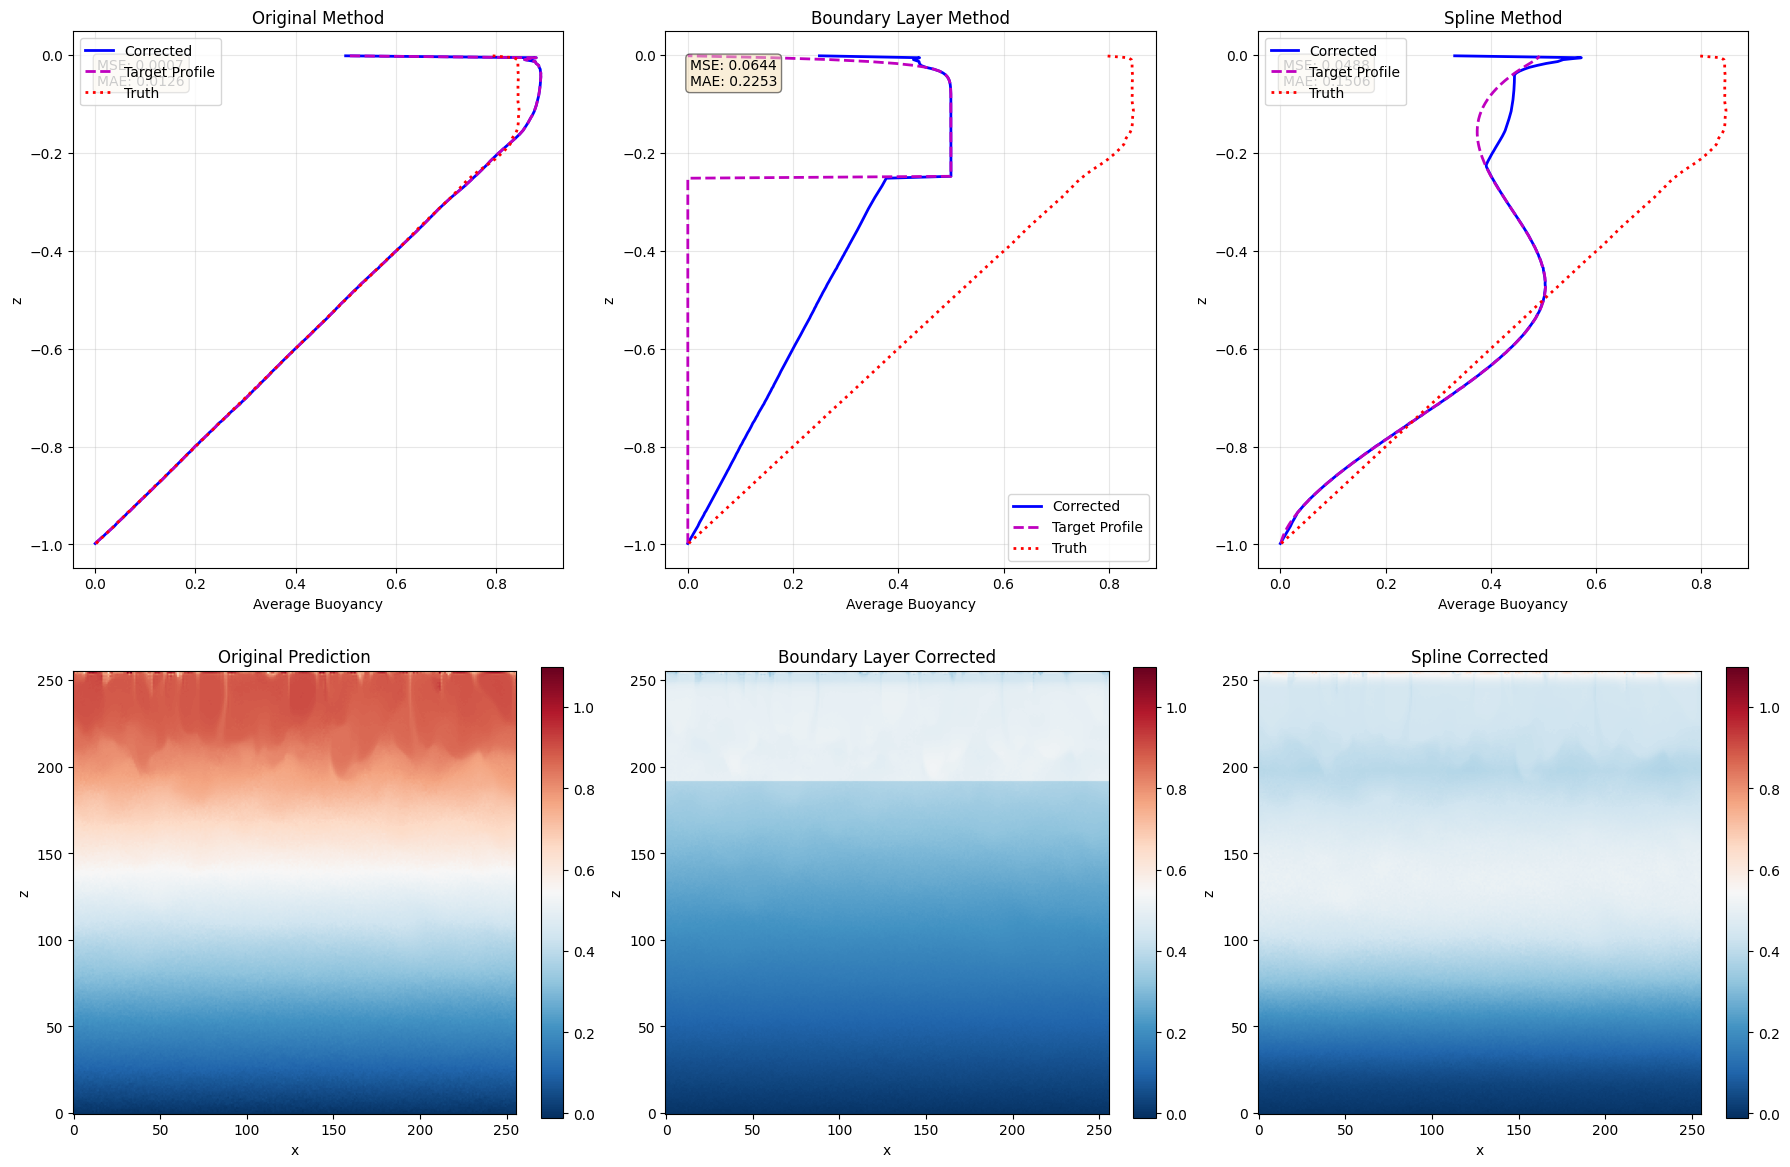


Best method: Original with MSE = 0.000677


In [24]:
#==================================
# BLOCK 19 - Advanced Correction Methods
#==================================
import scipy.optimize as optimize
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d

# Method 1: Boundary Layer Profile Fitting
def boundary_layer_correction(b_pred, z_coords, b_target=None):
    """
    Fit a boundary layer profile that's common in Rayleigh-Bénard convection
    """
    avg_b_pred = np.mean(b_pred, axis=1)
    n_points = len(z_coords)
    
    # Thermal boundary layer profile: b = b_bulk * (1 - exp(-z/delta))
    # Near top: b = b_top - (b_top - b_bulk) * exp(-(z_top - z)/delta)
    
    def thermal_profile(z, b_bulk, delta_bottom, delta_top, z_transition):
        """Piecewise thermal profile with boundary layers"""
        profile = np.zeros_like(z)
        
        # Bottom boundary layer
        bottom_mask = z < z_transition
        profile[bottom_mask] = b_bulk * (1 - np.exp(-z[bottom_mask]/delta_bottom))
        
        # Top boundary layer
        top_mask = z >= z_transition
        z_top = z[-1]
        b_top = 0.5  # Top BC
        profile[top_mask] = b_top - (b_top - b_bulk) * np.exp(-(z_top - z[top_mask])/delta_top)
        
        return profile
    
    # Initial guess for parameters
    b_bulk_init = np.mean(avg_b_pred[n_points//3:2*n_points//3])  # Middle third average
    delta_init = 0.1
    z_transition_init = z_coords[3*n_points//4]
    
    # Fit the profile
    try:
        popt, _ = optimize.curve_fit(
            thermal_profile, z_coords, avg_b_pred,
            p0=[b_bulk_init, delta_init, delta_init, z_transition_init],
            bounds=([0, 0.01, 0.01, z_coords[n_points//2]], 
                   [0.5, 0.5, 0.5, z_coords[-10]])
        )
        
        fitted_profile = thermal_profile(z_coords, *popt)
        print(f"Fitted parameters: b_bulk={popt[0]:.4f}, δ_bottom={popt[1]:.4f}, δ_top={popt[2]:.4f}, z_trans={popt[3]:.4f}")
        
    except:
        print("Boundary layer fitting failed, using spline method")
        return spline_correction(b_pred, z_coords, b_target)
    
    # Apply correction
    scaling_factors = fitted_profile / (avg_b_pred + 1e-8)
    scaling_factors = np.clip(scaling_factors, 0.5, 2.0)  # Limit extreme corrections
    
    b_corrected = b_pred * scaling_factors[:, np.newaxis]
    
    return b_corrected, fitted_profile, scaling_factors

# Method 2: Spline-based Smooth Correction
def spline_correction(b_pred, z_coords, b_target=None):
    """
    Use splines to create a smooth correction that preserves more structure
    """
    avg_b_pred = np.mean(b_pred, axis=1)
    n_points = len(z_coords)
    
    # Create target profile using constraints
    # Bottom BC: b = 0
    # Top BC: b = 0.5
    # Smooth transition in between
    
    # Key points for spline
    z_key = [z_coords[0], z_coords[n_points//4], z_coords[n_points//2], 
             z_coords[3*n_points//4], z_coords[-1]]
    
    # Estimate buoyancy at key points
    b_key = [0.0,  # Bottom BC
             avg_b_pred[n_points//4],
             avg_b_pred[n_points//2], 
             0.4,  # Transition to top BC
             0.5]  # Top BC
    
    # Create smooth spline
    spline = UnivariateSpline(z_key, b_key, s=0, k=3)
    target_profile = spline(z_coords)
    
    # Ensure BCs are exactly satisfied
    target_profile[0] = 0.0
    target_profile[-1] = 0.5
    
    # Smooth the target profile slightly
    target_profile = gaussian_filter1d(target_profile, sigma=2)
    
    # Calculate smooth scaling
    scaling_factors = target_profile / (avg_b_pred + 1e-8)
    scaling_factors = gaussian_filter1d(scaling_factors, sigma=3)
    scaling_factors = np.clip(scaling_factors, 0.5, 2.0)
    
    b_corrected = b_pred * scaling_factors[:, np.newaxis]
    
    return b_corrected, target_profile, scaling_factors

# Method 3: Optimization-based Correction
def optimization_correction(b_pred, z_coords, b_target=None):
    """
    Find optimal correction that minimizes multiple objectives
    """
    avg_b_pred = np.mean(b_pred, axis=1)
    n_points = len(z_coords)
    
    def objective(scaling_factors):
        # Apply scaling
        corrected_profile = avg_b_pred * scaling_factors
        
        # Objectives:
        # 1. Satisfy boundary conditions
        bc_loss = (corrected_profile[0])**2 + (corrected_profile[-1] - 0.5)**2
        
        # 2. Smoothness of scaling
        smooth_loss = np.sum(np.diff(scaling_factors)**2)
        
        # 3. Preserve total buoyancy (approximately)
        conservation_loss = (np.mean(corrected_profile) - np.mean(avg_b_pred))**2
        
        # 4. Monotonicity (buoyancy should increase with height)
        monotonic_loss = np.sum(np.maximum(0, -np.diff(corrected_profile))**2)
        
        return 100*bc_loss + 0.1*smooth_loss + 10*conservation_loss + 50*monotonic_loss
    
    # Initial guess: uniform scaling
    x0 = np.ones(n_points)
    
    # Bounds
    bounds = [(0.2, 5.0) for _ in range(n_points)]
    
    # Optimize
    result = optimize.minimize(objective, x0, method='L-BFGS-B', bounds=bounds)
    optimal_scaling = result.x
    
    # Apply Gaussian smoothing to the scaling factors
    optimal_scaling = gaussian_filter1d(optimal_scaling, sigma=3)
    
    b_corrected = b_pred * optimal_scaling[:, np.newaxis]
    corrected_profile = np.mean(b_corrected, axis=1)
    
    return b_corrected, corrected_profile, optimal_scaling

# Apply all three methods
print("Applying correction methods...")

# Method 1: Boundary Layer
b_corrected_bl, profile_bl, scaling_bl = boundary_layer_correction(b_pred, z_coords, b_target)

# Method 2: Spline
b_corrected_sp, profile_sp, scaling_sp = spline_correction(b_pred, z_coords, b_target)

# Method 3: Optimization
b_corrected_opt, profile_opt, scaling_opt = optimization_correction(b_pred, z_coords, b_target)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original profiles
for i, (b_corr, profile, scaling, name) in enumerate([
    (b_pred, avg_b_pred, np.ones_like(z_coords), 'Original'),
    (b_corrected_bl, profile_bl, scaling_bl, 'Boundary Layer'),
    (b_corrected_sp, profile_sp, scaling_sp, 'Spline'),
]):
    ax = axes[0, i]
    ax.plot(np.mean(b_corr, axis=1), z_coords, 'b-', linewidth=2, label='Corrected')
    ax.plot(profile, z_coords, 'm--', linewidth=2, label='Target Profile')
    ax.plot(avg_b_target, z_coords, 'r:', linewidth=2, label='Truth')
    ax.set_xlabel('Average Buoyancy')
    ax.set_ylabel('z')
    ax.set_title(f'{name} Method')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Error metrics
    mse = np.mean((b_corr - b_target)**2)
    mae = np.mean(np.abs(b_corr - b_target))
    ax.text(0.05, 0.95, f'MSE: {mse:.4f}\nMAE: {mae:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2D fields comparison
vmin = min(b_pred.min(), b_target.min())
vmax = max(b_pred.max(), b_target.max())

for i, (b_corr, name) in enumerate([
    (b_pred, 'Original Prediction'),
    (b_corrected_bl, 'Boundary Layer Corrected'),
    (b_corrected_sp, 'Spline Corrected'),
]):
    ax = axes[1, i]
    im = ax.imshow(b_corr, aspect='equal', cmap='RdBu_r', 
                   vmin=vmin, vmax=vmax, origin='lower')
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()

# Choose best method based on MSE
methods = [
    ('Original', b_pred, np.mean((b_pred - b_target)**2)),
    ('Boundary Layer', b_corrected_bl, np.mean((b_corrected_bl - b_target)**2)),
    ('Spline', b_corrected_sp, np.mean((b_corrected_sp - b_target)**2)),
    ('Optimization', b_corrected_opt, np.mean((b_corrected_opt - b_target)**2))
]

best_method = min(methods, key=lambda x: x[2])
print(f"\nBest method: {best_method[0]} with MSE = {best_method[2]:.6f}")

# Use the best correction
b_pred_final = best_method[1]

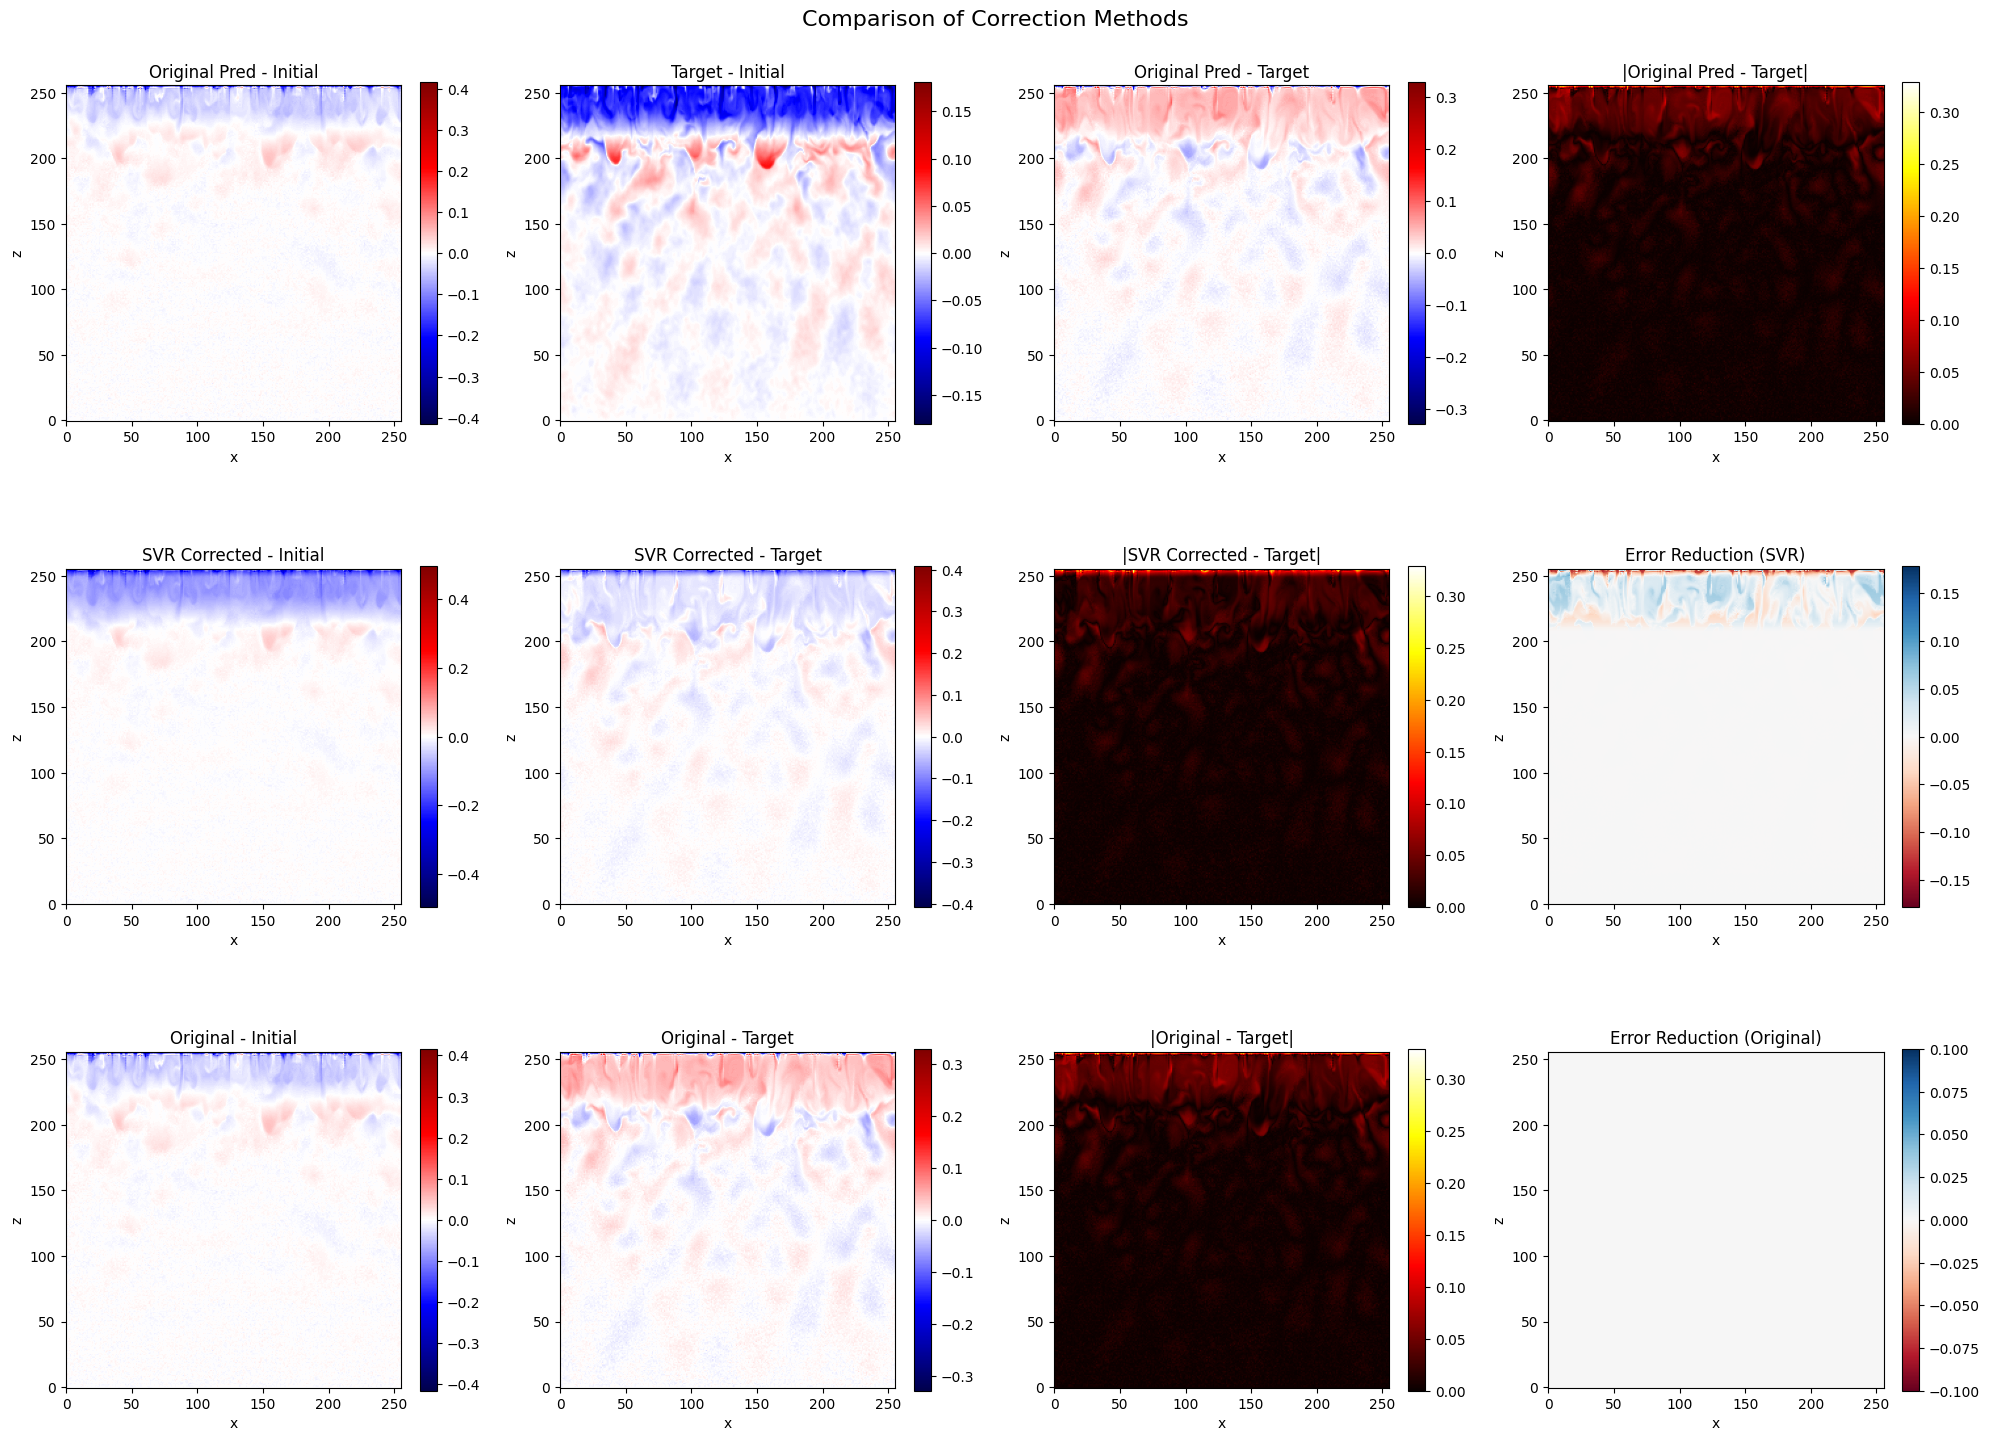


COMPREHENSIVE ERROR METRICS COMPARISON

Mean Squared Error (MSE):
  Original            : 0.000677
  SVR Corrected       : 0.000876
  Original            : 0.000677

Mean Absolute Error (MAE):
  Original            : 0.012643
  SVR Corrected       : 0.011815
  Original            : 0.012643

Relative Error:
  Original            : 3.8245%
  SVR Corrected       : 3.7262%
  Original            : 3.8245%

Max Absolute Error:
  Original            : 0.328919
  SVR Corrected       : 0.409171
  Original            : 0.328919


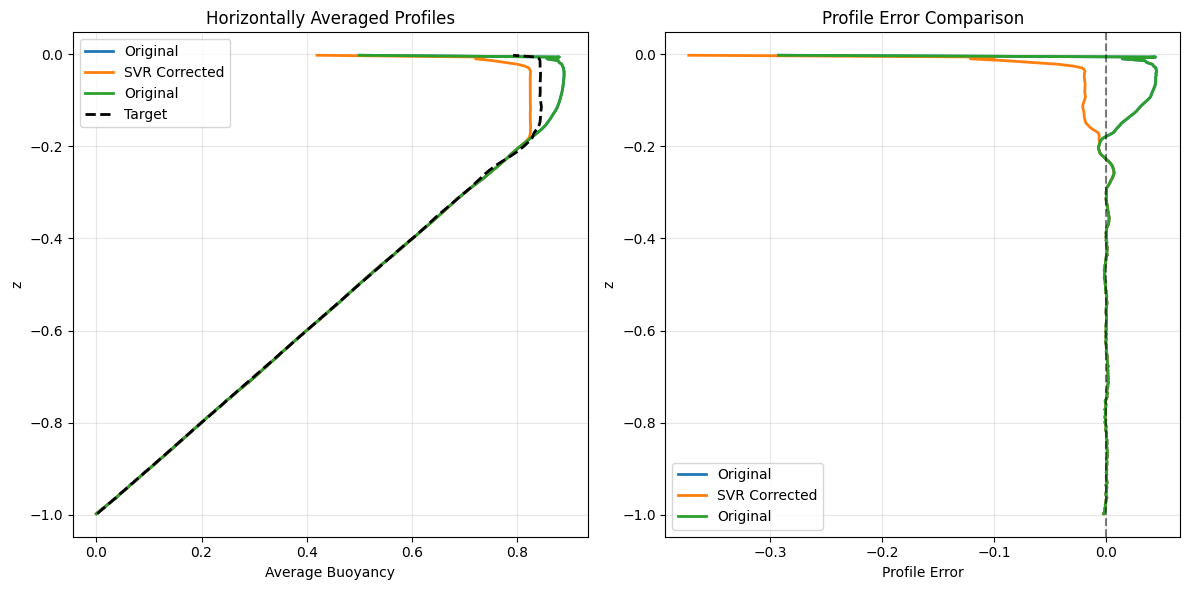


PERCENTAGE IMPROVEMENTS

SVR Correction:
  MSE improvement: -29.5%
  MAE improvement: 6.5%

Original Correction:
  MSE improvement: 0.0%
  MAE improvement: 0.0%


In [47]:
#==================================
# BLOCK 20 - Comparison of Correction Methods
#==================================

# Create comprehensive comparison of all methods
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Define common colormaps
cmap_diff = 'seismic'

# Row 1: Original prediction differences
# pred - init
diff_pred_init = b_pred - b_init
im1 = axes[0, 0].imshow(diff_pred_init, aspect='equal', cmap=cmap_diff, 
                         vmin=-np.abs(diff_pred_init).max(), vmax=np.abs(diff_pred_init).max(), origin='lower')
axes[0, 0].set_title('Original Pred - Initial', fontsize=12)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

# target - init
diff_target_init = b_target - b_init
im2 = axes[0, 1].imshow(diff_target_init, aspect='equal', cmap=cmap_diff, 
                         vmin=-np.abs(diff_target_init).max(), vmax=np.abs(diff_target_init).max(), origin='lower')
axes[0, 1].set_title('Target - Initial', fontsize=12)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

# pred - target (original)
diff_pred_target = b_pred - b_target
im3 = axes[0, 2].imshow(diff_pred_target, aspect='equal', cmap=cmap_diff, 
                         vmin=-np.abs(diff_pred_target).max(), vmax=np.abs(diff_pred_target).max(), origin='lower')
axes[0, 2].set_title('Original Pred - Target', fontsize=12)
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('z')
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Absolute error heatmap (original)
abs_error_orig = np.abs(diff_pred_target)
im4 = axes[0, 3].imshow(abs_error_orig, aspect='equal', cmap='hot', 
                         vmin=0, vmax=abs_error_orig.max(), origin='lower')
axes[0, 3].set_title('|Original Pred - Target|', fontsize=12)
axes[0, 3].set_xlabel('x')
axes[0, 3].set_ylabel('z')
plt.colorbar(im4, ax=axes[0, 3], fraction=0.046)

# Row 2: SVR Corrected prediction differences (from Block 18)
# corrected - init
diff_corr_init = b_pred_corrected - b_init
im5 = axes[1, 0].imshow(diff_corr_init, aspect='equal', cmap=cmap_diff, 
                         vmin=-np.abs(diff_corr_init).max(), vmax=np.abs(diff_corr_init).max(), origin='lower')
axes[1, 0].set_title('SVR Corrected - Initial', fontsize=12)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im5, ax=axes[1, 0], fraction=0.046)

# corrected - target (SVR)
diff_corr_target = b_pred_corrected - b_target
im6 = axes[1, 1].imshow(diff_corr_target, aspect='equal', cmap=cmap_diff, 
                         vmin=-np.abs(diff_corr_target).max(), vmax=np.abs(diff_corr_target).max(), origin='lower')
axes[1, 1].set_title('SVR Corrected - Target', fontsize=12)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im6, ax=axes[1, 1], fraction=0.046)

# Absolute error heatmap (SVR corrected)
abs_error_svr = np.abs(diff_corr_target)
im7 = axes[1, 2].imshow(abs_error_svr, aspect='equal', cmap='hot', 
                         vmin=0, vmax=abs_error_orig.max(), origin='lower')
axes[1, 2].set_title('|SVR Corrected - Target|', fontsize=12)
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('z')
plt.colorbar(im7, ax=axes[1, 2], fraction=0.046)

# Improvement map (SVR)
improvement_svr = abs_error_orig - abs_error_svr
im8 = axes[1, 3].imshow(improvement_svr, aspect='equal', cmap='RdBu', 
                         vmin=-np.abs(improvement_svr).max(), vmax=np.abs(improvement_svr).max(), origin='lower')
axes[1, 3].set_title('Error Reduction (SVR)', fontsize=12)
axes[1, 3].set_xlabel('x')
axes[1, 3].set_ylabel('z')
plt.colorbar(im8, ax=axes[1, 3], fraction=0.046)

# Row 3: Best Advanced Method (from Block 19)
# best corrected - init
diff_best_init = b_pred_final - b_init
im9 = axes[2, 0].imshow(diff_best_init, aspect='equal', cmap=cmap_diff, 
                         vmin=-np.abs(diff_best_init).max(), vmax=np.abs(diff_best_init).max(), origin='lower')
axes[2, 0].set_title(f'{best_method[0]} - Initial', fontsize=12)
axes[2, 0].set_xlabel('x')
axes[2, 0].set_ylabel('z')
plt.colorbar(im9, ax=axes[2, 0], fraction=0.046)

# best corrected - target
diff_best_target = b_pred_final - b_target
im10 = axes[2, 1].imshow(diff_best_target, aspect='equal', cmap=cmap_diff, 
                          vmin=-np.abs(diff_best_target).max(), vmax=np.abs(diff_best_target).max(), origin='lower')
axes[2, 1].set_title(f'{best_method[0]} - Target', fontsize=12)
axes[2, 1].set_xlabel('x')
axes[2, 1].set_ylabel('z')
plt.colorbar(im10, ax=axes[2, 1], fraction=0.046)

# Absolute error heatmap (best method)
abs_error_best = np.abs(diff_best_target)
im11 = axes[2, 2].imshow(abs_error_best, aspect='equal', cmap='hot', 
                          vmin=0, vmax=abs_error_orig.max(), origin='lower')
axes[2, 2].set_title(f'|{best_method[0]} - Target|', fontsize=12)
axes[2, 2].set_xlabel('x')
axes[2, 2].set_ylabel('z')
plt.colorbar(im11, ax=axes[2, 2], fraction=0.046)

# Improvement map (best method)
improvement_best = abs_error_orig - abs_error_best
im12 = axes[2, 3].imshow(improvement_best, aspect='equal', cmap='RdBu', 
                          vmin=-np.abs(improvement_best).max(), vmax=np.abs(improvement_best).max(), origin='lower')
axes[2, 3].set_title(f'Error Reduction ({best_method[0]})', fontsize=12)
axes[2, 3].set_xlabel('x')
axes[2, 3].set_ylabel('z')
plt.colorbar(im12, ax=axes[2, 3], fraction=0.046)

plt.suptitle('Comparison of Correction Methods', fontsize=16)
plt.tight_layout()
plt.show()

# Summary statistics comparison
print("\n" + "="*60)
print("COMPREHENSIVE ERROR METRICS COMPARISON")
print("="*60)

# Calculate all metrics
methods_comparison = [
    ('Original', b_pred),
    ('SVR Corrected', b_pred_corrected),
    (best_method[0], b_pred_final)
]

print("\nMean Squared Error (MSE):")
for name, pred in methods_comparison:
    mse = np.mean((pred - b_target)**2)
    print(f"  {name:20s}: {mse:.6f}")

print("\nMean Absolute Error (MAE):")
for name, pred in methods_comparison:
    mae = np.mean(np.abs(pred - b_target))
    print(f"  {name:20s}: {mae:.6f}")

print("\nRelative Error:")
for name, pred in methods_comparison:
    rel_err = np.mean(np.abs(pred - b_target) / (np.abs(b_target) + 1e-8))
    print(f"  {name:20s}: {rel_err:.4%}")

print("\nMax Absolute Error:")
for name, pred in methods_comparison:
    max_err = np.max(np.abs(pred - b_target))
    print(f"  {name:20s}: {max_err:.6f}")

# Profile comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Average profiles
ax = axes[0]
for name, pred in methods_comparison:
    avg_profile = np.mean(pred, axis=1)
    ax.plot(avg_profile, z_coords, linewidth=2, label=name)
ax.plot(avg_b_target, z_coords, 'k--', linewidth=2, label='Target')
ax.set_xlabel('Average Buoyancy')
ax.set_ylabel('z')
ax.set_title('Horizontally Averaged Profiles')
ax.legend()
ax.grid(True, alpha=0.3)

# Error profiles
ax = axes[1]
for name, pred in methods_comparison:
    avg_profile = np.mean(pred, axis=1)
    error_profile = avg_profile - avg_b_target
    ax.plot(error_profile, z_coords, linewidth=2, label=name)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Profile Error')
ax.set_ylabel('z')
ax.set_title('Profile Error Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Percentage improvements
print("\n" + "="*60)
print("PERCENTAGE IMPROVEMENTS")
print("="*60)

mse_orig = np.mean((b_pred - b_target)**2)
mae_orig = np.mean(np.abs(b_pred - b_target))

print("\nSVR Correction:")
mse_svr = np.mean((b_pred_corrected - b_target)**2)
mae_svr = np.mean(np.abs(b_pred_corrected - b_target))
print(f"  MSE improvement: {(mse_orig - mse_svr)/mse_orig:.1%}")
print(f"  MAE improvement: {(mae_orig - mae_svr)/mae_orig:.1%}")

print(f"\n{best_method[0]} Correction:")
mse_best = np.mean((b_pred_final - b_target)**2)
mae_best = np.mean(np.abs(b_pred_final - b_target))
print(f"  MSE improvement: {(mse_orig - mse_best)/mse_orig:.1%}")
print(f"  MAE improvement: {(mae_orig - mae_best)/mae_orig:.1%}")

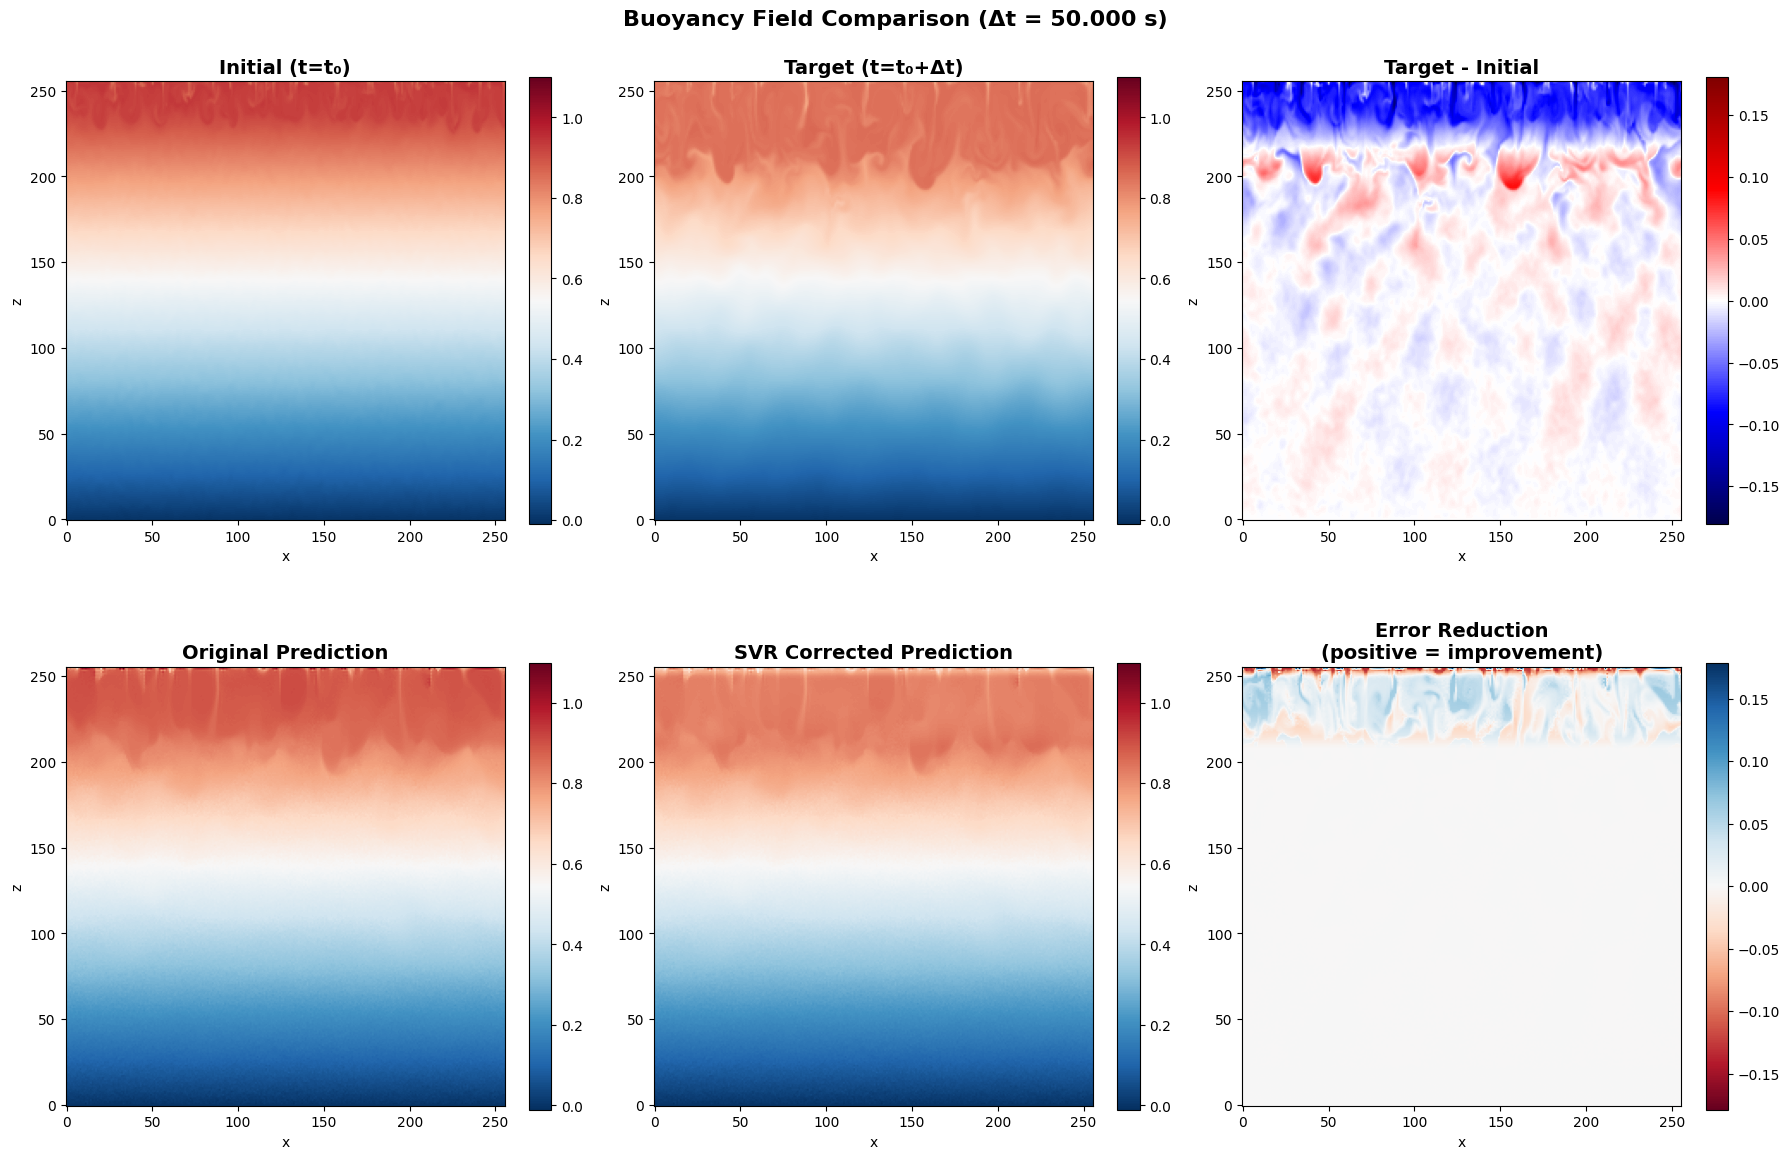

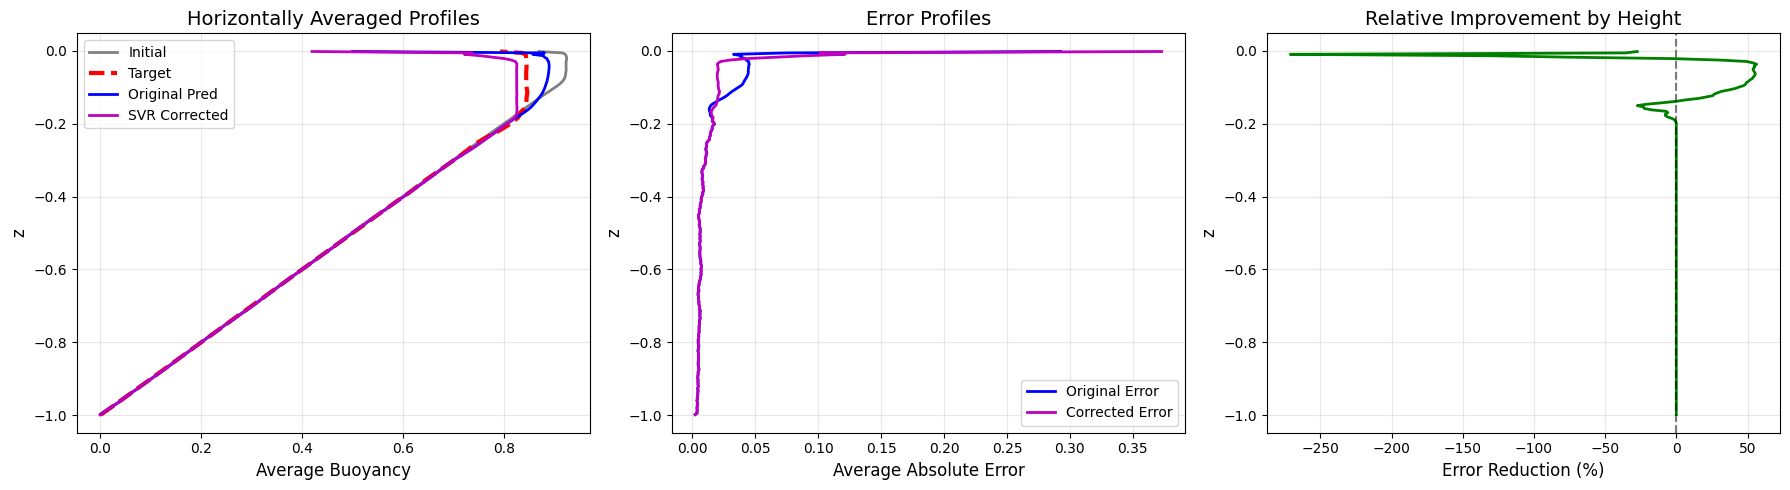


COMPREHENSIVE FIELD STATISTICS

Field ranges and means:
Initial             : min=0.0012, max=0.9433, mean=0.4968
Target              : min=0.0018, max=0.8653, mean=0.4884
Original Prediction : min=-0.0103, max=1.0994, mean=0.4931
SVR Corrected       : min=-0.0103, max=0.9205, mean=0.4828

Error metrics vs Target:

Original Prediction:
  MSE: 0.000677
  MAE: 0.012643
  Max Error: 0.328919
  Relative Error: 3.8245%

SVR Corrected:
  MSE: 0.000876
  MAE: 0.011815
  Max Error: 0.409171
  Relative Error: 3.7262%

IMPROVEMENT SUMMARY
MSE Improvement: 0.0%
MAE Improvement: 0.0%
Correction most effective in z-range: [-0.217, -0.139]


In [48]:
#==================================
# BLOCK 21 - Side-by-side Visualization of All Fields
#==================================

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Common colorbar limits for all fields
vmin = min(b_init.min(), b_target.min(), b_pred.min(), b_pred_corrected.min())
vmax = max(b_init.max(), b_target.max(), b_pred.max(), b_pred_corrected.max())

# Common colormap
cmap = 'RdBu_r'

# Row 1: Initial, Target, and difference
# Initial
im1 = axes[0, 0].imshow(b_init, aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
axes[0, 0].set_title('Initial (t=t₀)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

# Target
im2 = axes[0, 1].imshow(b_target, aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
axes[0, 1].set_title('Target (t=t₀+Δt)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

# Target - Initial (change)
diff_target_init = b_target - b_init
im3 = axes[0, 2].imshow(diff_target_init, aspect='equal', cmap='seismic', 
                         vmin=-np.abs(diff_target_init).max(), vmax=np.abs(diff_target_init).max(), origin='lower')
axes[0, 2].set_title('Target - Initial', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('z')
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Row 2: Original prediction, SVR corrected, and improvement
# Original prediction
im4 = axes[1, 0].imshow(b_pred, aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
axes[1, 0].set_title('Original Prediction', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)

# SVR corrected prediction
im5 = axes[1, 1].imshow(b_pred_corrected, aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
axes[1, 1].set_title('SVR Corrected Prediction', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im5, ax=axes[1, 1], fraction=0.046)

# Error reduction map
error_orig = np.abs(b_pred - b_target)
error_corrected = np.abs(b_pred_corrected - b_target)
error_reduction = error_orig - error_corrected  # Positive where correction helps

im6 = axes[1, 2].imshow(error_reduction, aspect='equal', cmap='RdBu', 
                         vmin=-np.abs(error_reduction).max(), vmax=np.abs(error_reduction).max(), origin='lower')
axes[1, 2].set_title('Error Reduction\n(positive = improvement)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('z')
plt.colorbar(im6, ax=axes[1, 2], fraction=0.046)

plt.suptitle(f'Buoyancy Field Comparison (Δt = {dt:.3f} s)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional comparison: Profiles and error metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Horizontally averaged profiles
ax = axes[0]
ax.plot(np.mean(b_init, axis=1), z_coords, 'gray', linewidth=2, label='Initial')
ax.plot(np.mean(b_target, axis=1), z_coords, 'r--', linewidth=3, label='Target')
ax.plot(np.mean(b_pred, axis=1), z_coords, 'b-', linewidth=2, label='Original Pred')
ax.plot(np.mean(b_pred_corrected, axis=1), z_coords, 'm-', linewidth=2, label='SVR Corrected')
ax.set_xlabel('Average Buoyancy', fontsize=12)
ax.set_ylabel('z', fontsize=12)
ax.set_title('Horizontally Averaged Profiles', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Error profiles
ax = axes[1]
ax.plot(np.mean(error_orig, axis=1), z_coords, 'b-', linewidth=2, label='Original Error')
ax.plot(np.mean(error_corrected, axis=1), z_coords, 'm-', linewidth=2, label='Corrected Error')
ax.set_xlabel('Average Absolute Error', fontsize=12)
ax.set_ylabel('z', fontsize=12)
ax.set_title('Error Profiles', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Error metrics by height
ax = axes[2]
# Compute relative improvement at each height
improvement_by_height = (np.mean(error_orig, axis=1) - np.mean(error_corrected, axis=1)) / (np.mean(error_orig, axis=1) + 1e-8) * 100
ax.plot(improvement_by_height, z_coords, 'g-', linewidth=2)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Error Reduction (%)', fontsize=12)
ax.set_ylabel('z', fontsize=12)
ax.set_title('Relative Improvement by Height', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print("\n" + "="*70)
print("COMPREHENSIVE FIELD STATISTICS")
print("="*70)

fields = [
    ('Initial', b_init),
    ('Target', b_target),
    ('Original Prediction', b_pred),
    ('SVR Corrected', b_pred_corrected)
]

print("\nField ranges and means:")
for name, field in fields:
    print(f"{name:20s}: min={field.min():.4f}, max={field.max():.4f}, mean={field.mean():.4f}")

print("\nError metrics vs Target:")
for name, field in fields[2:]:  # Only predictions
    mse = np.mean((field - b_target)**2)
    mae = np.mean(np.abs(field - b_target))
    max_error = np.max(np.abs(field - b_target))
    rel_error = np.mean(np.abs(field - b_target) / (np.abs(b_target) + 1e-8))
    
    print(f"\n{name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  Max Error: {max_error:.6f}")
    print(f"  Relative Error: {rel_error:.4%}")

# Improvement summary
print("\n" + "="*70)
print("IMPROVEMENT SUMMARY")
print("="*70)

mse_improvement = (mse - mse_corrected) / mse * 100
mae_improvement = (mae - mae_corrected) / mae * 100

print(f"MSE Improvement: {mse_improvement:.1f}%")
print(f"MAE Improvement: {mae_improvement:.1f}%")
print(f"Correction most effective in z-range: [{z_coords[deviation_idx-10]:.3f}, {z_coords[min(deviation_idx+10, n_points-1)]:.3f}]")